# Mount


In [1]:
from google.colab import drive 
drive.mount('/content/gdrive/')

%cd /content/gdrive/My\ Drive/TESIS/

Mounted at /content/gdrive/
/content/gdrive/My Drive/TESIS


# Import Librerías

In [2]:
!pip install tensorflow_addons  
!pip install gudhi
import pickle as pkl
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold, ShuffleSplit
from tensorflow import random_uniform_initializer as rui
import gudhi.representations as tda
import tensorflow as tf
import numpy as np
import os.path
import itertools
import h5py
import matplotlib.pyplot  as plt
import pandas             as pd
import tensorflow_addons  as tfa
import gudhi              as gd
from scipy.sparse           import csgraph
from scipy.io               import loadmat
from scipy.linalg           import eigh
from sklearn.preprocessing  import LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
# Reduccion dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


     |████████████████████████████████| 1.1 MB 5.1 MB/s 
     |████████████████████████████████| 29.3 MB 63.8 MB/s 


# Import no-bruto

In [3]:
!pip install git+https://github.com/MathieuCarriere/perslay
!pip install git+https://github.com/MathieuCarriere/sklearn-tda
from perslay import PerslayModel

  Cloning https://github.com/MathieuCarriere/perslay to /tmp/pip-req-build-wfmjubgb
  Running command git clone -q https://github.com/MathieuCarriere/perslay /tmp/pip-req-build-wfmjubgb
  Created wheel for perslay: filename=perslay-2.0-py3-none-any.whl size=9661 sha256=c7688e9525148e8f720df95b6f9d8ae7912743d1a55121d2d9f73317f437f09c
  Stored in directory: /tmp/pip-ephem-wheel-cache-8fts7m2j/wheels/ca/e3/0a/c67efd5f615cd051d2d655db0e6d8f4cd17a10ec609f13bbe0
Successfully built perslay
  Cloning https://github.com/MathieuCarriere/sklearn-tda to /tmp/pip-req-build-npuef4n8
  Running command git clone -q https://github.com/MathieuCarriere/sklearn-tda /tmp/pip-req-build-npuef4n8
  Running command git submodule update --init --recursive -q
  Created wheel for sklearn-tda: filename=sklearn_tda-0.0.0-py3-none-any.whl size=23622 sha256=1d12eaf735124d567334131dfaf98eca06d5965b837d85927101ea7d8ab4db40
  Stored in directory: /tmp/pip-ephem-wheel-cache-_c_6n9t4/wheels/c4/fa/0a/4cd7595b26b0d7b9c371ab

# Import bruto de PersLay

In [ ]:
!pip install tensorflow_addons  
!pip install gudhi
!git clone https://github.com/MathieuCarriere/perslay
!cd perslay
!(sudo) python setup.py install

     |████████████████████████████████| 706kB 4.5MB/s 
     |████████████████████████████████| 28.1MB 142kB/s 
fatal: destination path 'perslay' already exists and is not an empty directory.
/bin/bash: -c: line 0: syntax error near unexpected token `python'
/bin/bash: -c: line 0: `(sudo) python setup.py install'


In [ ]:
def permutation_equivariant_layer(inp, dimension, perm_op, lbda, b, gamma):
    """ DeepSet PersLay """
    dimension_before, num_pts = inp.shape[2], inp.shape[1]
    b = tf.expand_dims(tf.expand_dims(b, 0), 0)
    A = tf.reshape(tf.einsum("ijk,kl->ijl", inp, lbda), [-1, num_pts, dimension])
    if perm_op != None:
        if perm_op == "max":
            beta = tf.tile(tf.expand_dims(tf.math.reduce_max(inp, axis=1), 1), [1, num_pts, 1])
        elif perm_op == "min":
            beta = tf.tile(tf.expand_dims(tf.math.reduce_min(inp, axis=1), 1), [1, num_pts, 1])
        elif perm_op == "sum":
            beta = tf.tile(tf.expand_dims(tf.math.reduce_sum(inp, axis=1), 1), [1, num_pts, 1])
        else:
            raise Exception("perm_op should be min, max or sum")
        B = tf.reshape(tf.einsum("ijk,kl->ijl", beta, gamma), [-1, num_pts, dimension])
        return A - B + b
    else:
        return A + b

def rational_hat_layer(inp, q, mu, r):
    """ Rational Hat PersLay """
    mu, r = tf.expand_dims(tf.expand_dims(mu, 0), 0), tf.expand_dims(tf.expand_dims(r, 0), 0)
    dimension_before, num_pts = inp.shape[2], inp.shape[1]
    bc_inp = tf.expand_dims(inp, -1)
    norms = tf.norm(bc_inp - mu, ord=q, axis=2)
    return 1/(1 + norms) - 1/(1 + tf.math.abs(tf.math.abs(r)-norms)) 

def rational_layer(inp, mu, sg, al):
    """ Rational PersLay """
    mu, sg, al = tf.expand_dims(tf.expand_dims(mu, 0), 0), tf.expand_dims(tf.expand_dims(sg, 0), 0), tf.expand_dims(tf.expand_dims(al, 0), 0)
    dimension_before, num_pts = inp.shape[2], inp.shape[1]
    bc_inp = tf.expand_dims(inp, -1)
    return 1/tf.math.pow(1+tf.math.reduce_sum(tf.math.multiply(tf.math.abs(bc_inp - mu), tf.math.abs(sg)), axis=2), al)

def exponential_layer(inp, mu, sg):
    """ Exponential PersLay """
    mu, sg = tf.expand_dims(tf.expand_dims(mu, 0), 0), tf.expand_dims(tf.expand_dims(sg, 0), 0)
    dimension_before, num_pts = inp.shape[2], inp.shape[1]
    bc_inp = tf.expand_dims(inp, -1)
    return tf.math.exp(tf.math.reduce_sum(-tf.math.multiply(tf.math.square(bc_inp - mu), tf.math.square(sg)), axis=2))

def landscape_layer(inp, sp):
    """ Landscape PersLay """
    sp = tf.expand_dims(tf.expand_dims(sp, 0), 0)
    return tf.math.maximum( .5 * (inp[:, :, 1:2] - inp[:, :, 0:1]) - tf.math.abs(sp - .5 * (inp[:, :, 1:2] + inp[:, :, 0:1])), np.array([0]))

def betti_layer(inp, theta, sp):
    """ Betti PersLay """
    sp = tf.expand_dims(tf.expand_dims(sp, 0), 0)
    X, Y = inp[:, :, 0:1], inp[:, :, 1:2]
    return  1. / ( 1. + tf.math.exp( -theta * (.5*(Y-X) - tf.math.abs(sp - .5*(Y+X))) )  )

def entropy_layer(inp, theta, sp):
    """ Entropy PersLay
    WARNING: this function assumes that padding values are zero
    """
    sp = tf.expand_dims(tf.expand_dims(sp, 0), 0)
    bp_inp = tf.einsum("ijk,kl->ijl", inp, tf.constant(np.array([[1.,-1.],[0.,1.]], dtype=np.float32)))
    L, X, Y = bp_inp[:, :, 1:2], bp_inp[:, :, 0:1], bp_inp[:, :, 0:1] + bp_inp[:, :, 1:2]
    LN = tf.math.multiply(L, 1. / tf.expand_dims(tf.linalg.matmul(L[:,:,0], tf.ones([L.shape[1],1])), -1))
    entropy_terms = tf.where(LN > 0., -tf.math.multiply(LN, tf.math.log(LN)), LN)
    return  tf.math.multiply(entropy_terms, 1. / ( 1. + tf.math.exp( -theta * (.5*(Y-X) - tf.math.abs(sp - .5*(Y+X))) )  ))

def image_layer(inp, image_size, image_bnds, sg):
    """ Persistence Image PersLay """
    bp_inp = tf.einsum("ijk,kl->ijl", inp, tf.constant(np.array([[1.,-1.],[0.,1.]], dtype=np.float32)))
    dimension_before, num_pts = inp.shape[2], inp.shape[1]
    coords = [tf.range(start=image_bnds[i][0], limit=image_bnds[i][1], delta=(image_bnds[i][1] - image_bnds[i][0]) / image_size[i]) for i in range(dimension_before)]
    M = tf.meshgrid(*coords)
    mu = tf.concat([tf.expand_dims(tens, 0) for tens in M], axis=0)
    bc_inp = tf.reshape(bp_inp, [-1, num_pts, dimension_before] + [1 for _ in range(dimension_before)])
    return tf.expand_dims(tf.math.exp(tf.math.reduce_sum(  -tf.math.square(bc_inp-mu) / (2*tf.math.square(sg)),  axis=2)) / (2*np.pi*tf.math.square(sg)), -1)


class PerslayModel(tf.keras.Model):

    def __init__(self, name, diagdim, perslay_parameters, rho):
        super(PerslayModel, self).__init__()
        self.namemodel            = name
        self.diagdim              = diagdim
        self.perslay_parameters   = perslay_parameters
        self.rho                  = rho

        self.vars = [[] for _ in range(len(self.perslay_parameters))]
        for nf, plp in enumerate(self.perslay_parameters):

            weight = plp["pweight"]
            if weight != None:
                Winit, Wtrain, Wname = plp["pweight_init"], plp["pweight_train"], self.namemodel + "-pweight-" + str(nf)
                if not callable(Winit):
                    W = tf.Variable(name=Wname, initial_value=Winit, trainable=Wtrain)
                else:
                    if weight == "power":
                        W = tf.Variable(name=Wname, initial_value=Winit([1]), trainable=Wtrain)
                    elif weight == "grid":
                        Wshape = plp["pweight_size"]
                        W = tf.Variable(name=Wname, initial_value=Winit(Wshape), trainable=Wtrain)
                    elif weight == "gmix":
                        ngs = plp["pweight_num"] 
                        W = tf.Variable(name=Wname, initial_value=Winit([4,ngs]), trainable=Wtrain)
            else:
                W = 0
            self.vars[nf].append(W)

            layer, Ltrain, Lname = plp["layer"], plp["layer_train"], self.namemodel + "-" + str(nf)

            if layer == "PermutationEquivariant":
                Lpeq, LWinit, LBinit, LGinit = plp["lpeq"], plp["lweight_init"], plp["lbias_init"], plp["lgamma_init"]
                LW, LB, LG = [], [], []
                for idx, (dim, pop) in enumerate(Lpeq):
                    dim_before = self.diagdim if idx == 0 else Lpeq[idx-1][0]
                    LWiv = LWinit([dim_before, dim]) if callable(LWinit) else LWinit
                    LBiv = LBinit([dim]) if callable(LBinit) else LBinit
                    LW.append(      tf.Variable(name=Lname+"-W", initial_value=LWiv, trainable=Ltrain))
                    LB.append(      tf.Variable(name=Lname+"-B", initial_value=LBiv, trainable=Ltrain))
                    if pop != None:
                        LGiv = LGinit([dim_before, dim]) if callable(LGinit) else LGinit
                        LG.append(  tf.Variable(name=Lname+"-G", initial_value=LGiv, trainable=Ltrain))
                    else:
                        LG.append([])
                self.vars[nf].append([LW, LB, LG])

            elif layer == "Landscape" or layer == "BettiCurve" or layer == "Entropy":
                LSinit = plp["lsample_init"]
                LSiv = LSinit if not callable(LSinit) else LSinit([plp["lsample_num"]]) 
                LS = tf.Variable(name=Lname+"-S", initial_value=LSiv, trainable=Ltrain)
                self.vars[nf].append(LS)

            elif layer == "Image":
                LVinit = plp["lvariance_init"]
                LViv = LVinit if not callable(LVinit) else LVinit([1])
                LV = tf.Variable(name=Lname+"-V", initial_value=LViv, trainable=Ltrain)
                self.vars[nf].append(LV)

            elif layer == "Exponential":
                LMinit, LVinit = plp["lmean_init"], plp["lvariance_init"]
                LMiv = LMinit if not callable(LMinit) else LMinit([self.diagdim, plp["lnum"]])
                LViv = LVinit if not callable(LVinit) else LVinit([self.diagdim, plp["lnum"]])
                LM = tf.Variable(name=Lname+"-M", initial_value=LMiv, trainable=Ltrain)
                LV = tf.Variable(name=Lname+"-V", initial_value=LViv, trainable=Ltrain)
                self.vars[nf].append([LM, LV])

            elif layer == "Rational":
                LMinit, LVinit, LAinit = plp["lmean_init"], plp["lvariance_init"], plp["lalpha_init"]
                LMiv = LMinit if not callable(LMinit) else LMinit([self.diagdim, plp["lnum"]])
                LViv = LVinit if not callable(LVinit) else LVinit([self.diagdim, plp["lnum"]])
                LAiv = LAinit if not callable(LAinit) else LAinit([plp["lnum"]])
                LM = tf.Variable(name=Lname+"-M", initial_value=LMiv, trainable=Ltrain)
                LV = tf.Variable(name=Lname+"-V", initial_value=LViv, trainable=Ltrain)
                LA = tf.Variable(name=Lname+"-A", initial_value=LAiv, trainable=Ltrain)
                self.vars[nf].append([LM, LV, LA])

            elif layer == "RationalHat":
                LMinit, LRinit = plp["lmean_init"], plp["lr_init"]
                LMiv = LMinit if not callable(LMinit) else LMinit([self.diagdim, plp["lnum"]])
                LRiv = LRinit if not callable(LRinit) else LVinit([1])
                LM = tf.Variable(name=Lname+"-M", initial_value=LMiv, trainable=Ltrain)
                LR = tf.Variable(name=Lname+"-R", initial_value=LRiv, trainable=Ltrain)
                self.vars[nf].append([LM, LR])

    def compute_representations(self, diags, training=False):

        list_v = []

        for nf, plp in enumerate(self.perslay_parameters):

            diag = diags[nf]

            N, dimension_diag = diag.shape[1], diag.shape[2]
            tensor_mask = diag[:, :, dimension_diag - 1]
            tensor_diag = diag[:, :, :dimension_diag - 1]

            W = self.vars[nf][0]

            if plp["pweight"] == "power":
                p = plp["pweight_power"]
                weight = W * tf.math.pow(tf.math.abs(tensor_diag[:, :, 1:2]-tensor_diag[:, :, 0:1]), p)

            elif plp["pweight"] == "grid":
                grid_shape = W.shape  
                indices = []
                for dim in range(dimension_diag-1):
                    [m, M] = plp["pweight_bnds"][dim]
                    coords = tf.slice(tensor_diag, [0, 0, dim], [-1, -1, 1])
                    ids = grid_shape[dim] * (coords - m)/(M - m)
                    indices.append(tf.cast(ids, tf.int32))
                weight = tf.expand_dims(tf.gather_nd(params=W, indices=tf.concat(indices, axis=2)), -1)

            elif plp["pweight"] == "gmix":
                M, V = tf.expand_dims(tf.expand_dims(W[:2,:], 0), 0), tf.expand_dims(tf.expand_dims(W[2:,:], 0), 0) 
                bc_inp = tf.expand_dims(tensor_diag, -1)
                weight = tf.expand_dims(tf.math.reduce_sum(tf.math.exp(tf.math.reduce_sum(-tf.math.multiply(tf.math.square(bc_inp-M), tf.math.square(V)), axis=2)), axis=2), -1)


            lvars = self.vars[nf][1]
            if plp["layer"] == "PermutationEquivariant":
                for idx, (dim, pop) in enumerate(plp["lpeq"]):
                    tensor_diag = permutation_equivariant_layer(tensor_diag, dim, pop, lvars[0][idx], lvars[1][idx], lvars[2][idx])
            elif plp["layer"] == "Landscape":
                tensor_diag = landscape_layer(tensor_diag, lvars)
            elif plp["layer"] == "BettiCurve":
                tensor_diag = betti_layer(tensor_diag, plp["theta"], lvars)
            elif plp["layer"] == "Entropy":
                tensor_diag = entropy_layer(tensor_diag, plp["theta"], lvars)
            elif plp["layer"] == "Image":
                tensor_diag = image_layer(tensor_diag, plp["image_size"], plp["image_bnds"], lvars)
            elif plp["layer"] == "Exponential":
                tensor_diag = exponential_layer(tensor_diag, **lvars)
            elif plp["layer"] == "Rational":
                tensor_diag = rational_layer(tensor_diag, **lvars)
            elif plp["layer"] == "RationalHat":
                tensor_diag = rational_hat_layer(tensor_diag, plp["q"], **lvars)

            # Apply weight
            output_dim = len(tensor_diag.shape) - 2
            if plp["pweight"] != None:
                for _ in range(output_dim-1):
                    weight = tf.expand_dims(weight, -1)
                tiled_weight = tf.tile(weight, [1, 1] + tensor_diag.shape[2:])
                tensor_diag = tf.math.multiply(tensor_diag, tiled_weight)

            # Apply mask
            for _ in range(output_dim):
                tensor_mask = tf.expand_dims(tensor_mask, -1)
            tiled_mask = tf.tile(tensor_mask, [1, 1] + tensor_diag.shape[2:])
            masked_layer = tf.math.multiply(tensor_diag, tiled_mask)

            # Permutation invariant operation
            if plp["perm_op"] == "topk" and output_dim == 1:  # k first values
                masked_layer_t = tf.transpose(masked_layer, perm=[0, 2, 1])
                values, indices = tf.math.top_k(masked_layer_t, k=plp["keep"])
                vector = tf.reshape(values, [-1, plp["keep"] * tensor_diag.shape[2]])
            elif plp["perm_op"] == "sum":  # sum
                vector = tf.math.reduce_sum(masked_layer, axis=1)
            elif plp["perm_op"] == "max":  # maximum
                vector = tf.math.reduce_max(masked_layer, axis=1)
            elif plp["perm_op"] == "mean":  # minimum
                vector = tf.math.reduce_mean(masked_layer, axis=1)

            # Second layer of channel
            vector = plp["final_model"].call(vector, training=training) if plp["final_model"] != "identity" else vector
            list_v.append(vector)

        # Concatenate all channels and add other features
        representations = tf.concat(values=list_v, axis=1)
        return representations

    def call(self, inputs, training=False):

        diags, feats = inputs[0], inputs[1]
        representations = self.compute_representations(diags, training)
        concat_representations = tf.concat(values=[representations, feats], axis=1)
        final_representations = self.rho(concat_representations) if self.rho != "identity" else concat_representations

        return final_representations



def get_parameters(dataset):
    if dataset == "MUTAG" or dataset == "PROTEINS":
        dataset_parameters = {"data_type": "graph", "filt_names": ["Ord0_10.0-hks", "Rel1_10.0-hks", "Ext0_10.0-hks", "Ext1_10.0-hks"]}
    elif dataset == "COX2" or dataset == "DHFR" or dataset == "NCI1" or dataset == "NCI109" or dataset == "IMDB-BINARY" or dataset == "IMDB-MULTI":
        dataset_parameters = {"data_type": "graph", "filt_names": ["Ord0_0.1-hks", "Rel1_0.1-hks", "Ext0_0.1-hks", "Ext1_0.1-hks", "Ord0_10.0-hks", "Rel1_10.0-hks", "Ext0_10.0-hks", "Ext1_10.0-hks"]}
    elif dataset == "ORBIT5K" or dataset == "ORBIT100K":
        dataset_parameters = {"data_type": "orbit", "filt_names": ["Alpha0", "Alpha1"]}
    return dataset_parameters

def get_model(dataset, nf):

    if dataset == "MUTAG":

        plp = {}
        plp["pweight"]        = "grid"
        plp["pweight_init"]   = rui(1., 1.)
        plp["pweight_size"]   = (10, 10)
        plp["pweight_bnds"]   = ((-0.001, 1.001), (-0.001, 1.001))
        plp["pweight_train"]  = True
        plp["layer"]          = "Image"
        plp["image_size"]     = (20, 20)
        plp["image_bnds"]     = ((-0.001, 1.001), (-0.001, 1.001))
        plp["lvariance_init"] = rui(3., 3.)
        plp["layer_train"]    = True
        plp["perm_op"]        = "sum"
        perslay_parameters    = [plp for _ in range(4)]

        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            for i in range(4):
                fmodel = tf.keras.Sequential([tf.keras.layers.Conv2D(10, 2, input_shape=(21,21,1)), tf.keras.layers.Flatten()])
                perslay_parameters[i]["final_model"] = fmodel
            rho = tf.keras.Sequential([tf.keras.layers.Dense(2, activation="sigmoid", input_shape=(16000+nf,))])
            model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
            lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=20, decay_rate=0.5, staircase=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
            optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 
            loss = tf.keras.losses.CategoricalCrossentropy()
            metrics = [tf.keras.metrics.CategoricalAccuracy()]

    elif dataset == "PROTEINS":

        plp = {}
        plp["pweight"]        = "grid"
        plp["pweight_init"]   = rui(1., 1.)
        plp["pweight_size"]   = (10, 10)
        plp["pweight_bnds"]   = ((-0.001, 1.001), (-0.001, 1.001))
        plp["pweight_train"]  = True
        plp["layer"]          = "Image"
        plp["image_size"]     = (15, 15)
        plp["image_bnds"]     = ((-0.001, 1.001), (-0.001, 1.001))
        plp["lvariance_init"] = rui(3., 3.)
        plp["layer_train"]    = True
        plp["perm_op"]        = "sum"
        perslay_parameters    = [plp for _ in range(4)]

        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            for i in range(4):
                fmodel = tf.keras.Sequential([tf.keras.layers.Conv2D(10, 2, input_shape=(16,16,1)), tf.keras.layers.Flatten()])
                perslay_parameters[i]["final_model"] = fmodel
            rho = tf.keras.Sequential([tf.keras.layers.Dense(2, activation="sigmoid", input_shape=(9000+nf,))])
            model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
            lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=20, decay_rate=0.5, staircase=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
            optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 
            loss = tf.keras.losses.CategoricalCrossentropy()
            metrics = [tf.keras.metrics.CategoricalAccuracy()]

    elif dataset == "NCI1" or dataset == "NCI109":

        plp = {}
        plp["pweight"]        = "grid"
        plp["pweight_init"]   = rui(1., 1.)
        plp["pweight_size"]   = (10, 10)
        plp["pweight_bnds"]   = ((-0.001, 1.001), (-0.001, 1.001))
        plp["pweight_train"]  = True
        plp["layer"]          = "PermutationEquivariant"
        plp["lpeq"]           = [(25, None), (25, "max")]
        plp["layer_train"]    = True
        plp["perm_op"]        = "sum"
        plp["final_model"]    = "identity"
        perslay_parameters    = [plp for _ in range(8)]

        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            rho = tf.keras.Sequential([tf.keras.layers.Dense(2, activation="sigmoid", input_shape=(200+nf,))])
            model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
            lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=20, decay_rate=0.5, staircase=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
            optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 
            loss = tf.keras.losses.CategoricalCrossentropy()
            metrics = [tf.keras.metrics.CategoricalAccuracy()]

    elif dataset == "IMDB-MULTI" or dataset == "IMDB-BINARY":

        nlab = 2 if dataset == "IMDB-BINARY" else 3
        plp = {}
        plp["pweight"]        = "grid"
        plp["pweight_init"]   = rui(1., 1.)
        plp["pweight_size"]   = (20, 20)
        plp["pweight_bnds"]   = ((-0.001, 1.001), (-0.001, 1.001))
        plp["pweight_train"]  = True
        plp["layer"]          = "Image"
        plp["image_size"]     = (20, 20)
        plp["image_bnds"]     = ((-0.001, 1.001), (-0.001, 1.001))
        plp["lvariance_init"] = rui(3., 3.)
        plp["layer_train"]    = True
        plp["perm_op"]        = "sum"
        perslay_parameters    = [plp for _ in range(8)]

        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            for i in range(8):
                fmodel = tf.keras.Sequential([tf.keras.layers.Conv2D(10, 2, input_shape=(21,21,1)), tf.keras.layers.Flatten()])
                perslay_parameters[i]["final_model"] = fmodel
            rho = tf.keras.Sequential([tf.keras.layers.Dense(nlab, activation="sigmoid", input_shape=(32000+nf,))])
            model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
            lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=20, decay_rate=0.5, staircase=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
            optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 
            loss = tf.keras.losses.CategoricalCrossentropy()
            metrics = [tf.keras.metrics.CategoricalAccuracy()]

    elif dataset == "COX2" or dataset == "DHFR":

        plp = {}
        plp["pweight"]        = "grid"
        plp["pweight_init"]   = rui(1., 1.)
        plp["pweight_size"]   = (10, 10)
        plp["pweight_bnds"]   = ((-0.001, 1.001), (-0.001, 1.001))
        plp["pweight_train"]  = True
        plp["layer"]          = "Image"
        plp["image_size"]     = (20, 20)
        plp["image_bnds"]     = ((-0.001, 1.001), (-0.001, 1.001))
        plp["lvariance_init"] = rui(3., 3.)
        plp["layer_train"]    = True
        plp["perm_op"]        = "sum"
        perslay_parameters    = [plp for _ in range(8)]

        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            for i in range(8):
                fmodel = tf.keras.Sequential([tf.keras.layers.Conv2D(10, 2, input_shape=(21,21,1)), tf.keras.layers.Flatten()])
                perslay_parameters[i]["final_model"] = fmodel
            rho = tf.keras.Sequential([tf.keras.layers.Dense(2, activation="sigmoid", input_shape=(32000+nf,))])
            model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
            lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=20, decay_rate=0.5, staircase=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
            optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 
            loss = tf.keras.losses.CategoricalCrossentropy()
            metrics = [tf.keras.metrics.CategoricalAccuracy()]

    elif dataset == "ORBIT5K" or dataset == "ORBIT100K":

        plp = {}
        plp["pweight"]        = "grid"
        plp["pweight_init"]   = rui(1., 1.)
        plp["pweight_size"]   = (10, 10)
        plp["pweight_bnds"]   = ((-0.001, 1.001), (-0.001, 1.001))
        plp["pweight_train"]  = True
        plp["layer"]          = "PermutationEquivariant"
        plp["lpeq"]           = [(25, None), (25, "max")]
        plp["lweight_init"]   = rui(0.,1.)
        plp["lbias_init"]     = rui(0.,1.)
        plp["lgamma_init"]    = rui(0.,1.)
        plp["layer_train"]    = True
        plp["perm_op"]        = "topk"
        plp["keep"]           = 5
        plp["final_model"]    = "identity"
        perslay_parameters    = [plp for _ in range(2)]

        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            rho = tf.keras.Sequential([tf.keras.layers.Dense(5, activation="sigmoid", input_shape=(250+nf,))])
            model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
            lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=20, decay_rate=1., staircase=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
            optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 
            loss = tf.keras.losses.CategoricalCrossentropy()
            metrics = [tf.keras.metrics.CategoricalAccuracy()]

    return model, optimizer, loss, metrics

def hks_signature(eigenvectors, eigenvals, time):
    return np.square(eigenvectors).dot(np.diag(np.exp(-time * eigenvals))).sum(axis=1)

def generate_orbit(num_pts_per_orbit, param):
    X = np.zeros([num_pts_per_orbit, 2])
    xcur, ycur = np.random.rand(), np.random.rand()
    for idx in range(num_pts_per_orbit):
        xcur = (xcur + param * ycur * (1. - ycur)) % 1
        ycur = (ycur + param * xcur * (1. - xcur)) % 1
        X[idx, :] = [xcur, ycur]
    return X

def apply_graph_extended_persistence(A, filtration_val):
    num_vertices = A.shape[0]
    (xs, ys) = np.where(np.triu(A))
    st = gd.SimplexTree()
    for i in range(num_vertices):
        st.insert([i], filtration=-1e10)
    for idx, x in enumerate(xs):        
        st.insert([x, ys[idx]], filtration=-1e10)
    for i in range(num_vertices):
        st.assign_filtration([i], filtration_val[i])
    st.make_filtration_non_decreasing()
    st.extend_filtration()
    LD = st.extended_persistence()
    dgmOrd0, dgmRel1, dgmExt0, dgmExt1 = LD[0], LD[1], LD[2], LD[3]
    dgmOrd0 = np.vstack([np.array([[ min(p[1][0],p[1][1]), max(p[1][0],p[1][1]) ]]) for p in dgmOrd0 if p[0] == 0]) if len(dgmOrd0) else np.empty([0,2])
    dgmRel1 = np.vstack([np.array([[ min(p[1][0],p[1][1]), max(p[1][0],p[1][1]) ]]) for p in dgmRel1 if p[0] == 1]) if len(dgmRel1) else np.empty([0,2])
    dgmExt0 = np.vstack([np.array([[ min(p[1][0],p[1][1]), max(p[1][0],p[1][1]) ]]) for p in dgmExt0 if p[0] == 0]) if len(dgmExt0) else np.empty([0,2])
    dgmExt1 = np.vstack([np.array([[ min(p[1][0],p[1][1]), max(p[1][0],p[1][1]) ]]) for p in dgmExt1 if p[0] == 1]) if len(dgmExt1) else np.empty([0,2])
    return dgmOrd0, dgmExt0, dgmRel1, dgmExt1

def generate_diagrams_and_features(dataset, path_dataset=""):

    dataset_parameters = get_parameters(dataset)
    dataset_type = dataset_parameters["data_type"]

    if "REDDIT" in dataset:
        print("Unfortunately, REDDIT data are not available yet for memory issues.\n")
        print("Moreover, the link we used to download the data,")
        print("http://www.mit.edu/~pinary/kdd/datasets.tar.gz")
        print("is down at the commit time (May 23rd).")
        print("We will update this repository when we figure out a workaround.")
        return

    path_dataset = "./data/" + dataset + "/" if not len(path_dataset) else path_dataset
    if os.path.isfile(path_dataset + dataset + ".hdf5"):
        os.remove(path_dataset + dataset + ".hdf5")
    diag_file = h5py.File(path_dataset + dataset + ".hdf5", "w")
    list_filtrations = dataset_parameters["filt_names"]
    [diag_file.create_group(str(filtration)) for filtration in dataset_parameters["filt_names"]]
    
    if dataset_type == "graph":

        list_hks_times = np.unique([filtration.split("_")[1] for filtration in list_filtrations])

        # preprocessing
        pad_size = 1
        for graph_name in os.listdir(path_dataset + "mat/"):
            A = np.array(loadmat(path_dataset + "mat/" + graph_name)["A"], dtype=np.float32)
            pad_size = np.max((A.shape[0], pad_size))

        feature_names = ["eval"+str(i) for i in range(pad_size)] + [name+"-percent"+str(i) for name, i in itertools.product([f for f in list_hks_times if "hks" in f], 10*np.arange(11))]
        features = pd.DataFrame(index=range(len(os.listdir(path_dataset + "mat/"))), columns=["label"] + feature_names)

        for idx, graph_name in enumerate((os.listdir(path_dataset + "mat/"))):

            name = graph_name.split("_")
            gid = int(name[name.index("gid") + 1]) - 1
            A = np.array(loadmat(path_dataset + "mat/" + graph_name)["A"], dtype=np.float32)
            num_vertices = A.shape[0]
            label = int(name[name.index("lb") + 1])

            L = csgraph.laplacian(A, normed=True)
            egvals, egvectors = eigh(L)
            eigenvectors = np.zeros([num_vertices, pad_size])
            eigenvals = np.zeros(pad_size)
            eigenvals[:min(pad_size, num_vertices)] = np.flipud(egvals)[:min(pad_size, num_vertices)]
            eigenvectors[:, :min(pad_size, num_vertices)] = np.fliplr(egvectors)[:, :min(pad_size, num_vertices)]
            graph_features = []
            graph_features.append(eigenvals)

            for fhks in list_hks_times:
                hks_time = float(fhks.split("-")[0])
                filtration_val = hks_signature(egvectors, egvals, time=hks_time)
                dgmOrd0, dgmExt0, dgmRel1, dgmExt1 = apply_graph_extended_persistence(A, filtration_val)
                diag_file["Ord0_" + str(hks_time) + "-hks"].create_dataset(name=str(gid), data=dgmOrd0)
                diag_file["Ext0_" + str(hks_time) + "-hks"].create_dataset(name=str(gid), data=dgmExt0)
                diag_file["Rel1_" + str(hks_time) + "-hks"].create_dataset(name=str(gid), data=dgmRel1)
                diag_file["Ext1_" + str(hks_time) + "-hks"].create_dataset(name=str(gid), data=dgmExt1)
                graph_features.append(np.percentile(hks_signature(eigenvectors, eigenvals, time=hks_time), 10 * np.arange(11)))
            features.loc[gid] = np.insert(np.concatenate(graph_features), 0, label)
        features["label"] = features["label"].astype(int)

    elif dataset_type == "orbit":

        labs = []
        count = 0
        num_diag_per_param = 1000 if "5K" in dataset else 20000
        for lab, r in enumerate([2.5, 3.5, 4.0, 4.1, 4.3]):
            print("Generating", num_diag_per_param, "orbits and diagrams for r = ", r, "...")
            for dg in range(num_diag_per_param):
                X = generate_orbit(num_pts_per_orbit=1000, param=r)
                alpha_complex = gd.AlphaComplex(points=X)
                st = alpha_complex.create_simplex_tree(max_alpha_square=1e50)
                st.persistence()
                diag_file["Alpha0"].create_dataset(name=str(count), data=np.array(st.persistence_intervals_in_dimension(0)))
                diag_file["Alpha1"].create_dataset(name=str(count), data=np.array(st.persistence_intervals_in_dimension(1)))
                orbit_label = {"label": lab, "pcid": count}
                labs.append(orbit_label)
                count += 1
        labels = pd.DataFrame(labs)
        labels.set_index("pcid")
        features = labels[["label"]]

    features.to_csv(path_dataset + dataset + ".csv")

    return diag_file.close()

def load_data(dataset, path_dataset="", filtrations=[], verbose=False):

    path_dataset = "./data/" + dataset + "/" if not len(path_dataset) else path_dataset
    diagfile = h5py.File(path_dataset + dataset + ".hdf5", "r")
    filts = list(diagfile.keys()) if len(filtrations) == 0 else filtrations

    diags_dict = dict()
    if len(filts) == 0:
        filts = diagfile.keys()
    for filtration in filts:
        list_dgm, num_diag = [], len(diagfile[filtration].keys())
        for diag in range(num_diag):
            list_dgm.append(np.array(diagfile[filtration][str(diag)]))
        diags_dict[filtration] = list_dgm

    # Extract features and encode labels with integers
    feat = pd.read_csv(path_dataset + dataset + ".csv", index_col=0, header=0)
    F = np.array(feat)[:, 1:]  # 1: removes the labels
    L = np.array(LabelEncoder().fit_transform(np.array(feat["label"])))
    L = OneHotEncoder(sparse=False, categories="auto").fit_transform(L[:, np.newaxis])

    if verbose:
        print("Dataset:", dataset)
        print("Number of observations:", L.shape[0])
        print("Number of classes:", L.shape[1])

    return diags_dict, F, L

def visualize_diagrams(diags_dict, ilist=(0, 10, 20, 30, 40, 50)):
    filts = diags_dict.keys()
    n, m = len(filts), len(ilist)
    fig, axs = plt.subplots(n, m, figsize=(m*n / 2, n*m / 2))
    for (i, filtration) in enumerate(filts):
        for (j, idx) in enumerate(ilist):
            xs, ys = diags_dict[filtration][idx][:, 0], diags_dict[filtration][idx][:, 1]
            axs[i, j].scatter(xs, ys)
            axs[i, j].plot([0, 1], [0, 1])
            axs[i, j].axis([0, 1, 0, 1])
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
    # axis plot
    cols = ["idx = " + str(i) for i in ilist]
    rows = filts
    for ax, col in zip(axs[0], cols):
        ax.set_title(col)
    for ax, row in zip(axs[:, 0], rows):
        ax.set_ylabel(row, rotation=90, size="large")
    plt.show()
    return

def evaluate_model(L, F, D, train_sub, test_sub, model, optimizer, loss, metrics, num_epochs, batch_size=128, verbose=1, plots=False):

    num_pts, num_labels, num_features, num_filt = L.shape[0], L.shape[1], F.shape[1], len(D)

    train_num_pts, test_num_pts = len(train_sub), len(test_sub)
    label_train, label_test = L[train_sub, :], L[test_sub, :]
    feats_train, feats_test = F[train_sub, :], F[test_sub, :]
    diags_train, diags_test = [D[dt][train_sub, :] for dt in range(num_filt)], [D[dt][test_sub, :] for dt in range(num_filt)]

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    history = model.fit(x=[diags_train, feats_train], y=label_train, validation_data=([diags_test, feats_test], label_test), epochs=num_epochs, batch_size=batch_size, shuffle=True, verbose=verbose)
    train_results = model.evaluate([diags_train, feats_train], label_train, verbose=verbose)
    test_results = model.evaluate([diags_test,  feats_test],  label_test, verbose=verbose)
    
    if plots:
        ltrain, ltest = history.history["categorical_accuracy"], history.history["val_categorical_accuracy"]
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(np.array(ltrain), color="blue", label="train acc")
        ax.plot(np.array(ltest),  color="red",  label="test acc")
        ax.set_ylim(top=1.)
        ax.legend()
        ax.set_xlabel("epochs")
        ax.set_ylabel("classif. accuracy")
        ax.set_title("Evolution of train/test accuracy")
        plt.show()

    return history.history, train_results, test_results

In [ ]:
import os.path
import itertools
import h5py
import numpy              as np
import matplotlib.pyplot  as plt
import pandas             as pd
import tensorflow         as tf
import tensorflow_addons  as tfa
import gudhi              as gd

from scipy.sparse           import csgraph
from scipy.io               import loadmat
from scipy.linalg           import eigh
from sklearn.preprocessing  import LabelEncoder, OneHotEncoder
from tensorflow             import random_uniform_initializer as rui
#from perslay                import PerslayModel


def get_parameters(dataset):
    if dataset == "MUTAG" or dataset == "PROTEINS":
        dataset_parameters = {"data_type": "graph", "filt_names": ["Ord0_10.0-hks", "Rel1_10.0-hks", "Ext0_10.0-hks", "Ext1_10.0-hks"]}
    elif dataset == "COX2" or dataset == "DHFR" or dataset == "NCI1" or dataset == "NCI109" or dataset == "IMDB-BINARY" or dataset == "IMDB-MULTI":
        dataset_parameters = {"data_type": "graph", "filt_names": ["Ord0_0.1-hks", "Rel1_0.1-hks", "Ext0_0.1-hks", "Ext1_0.1-hks", "Ord0_10.0-hks", "Rel1_10.0-hks", "Ext0_10.0-hks", "Ext1_10.0-hks"]}
    elif dataset == "ORBIT5K" or dataset == "ORBIT100K":
        dataset_parameters = {"data_type": "orbit", "filt_names": ["Alpha0", "Alpha1"]}
    return dataset_parameters

def get_model(dataset, nf):

    if dataset == "MUTAG":

        plp = {}
        plp["pweight"]        = "grid"
        plp["pweight_init"]   = rui(1., 1.)
        plp["pweight_size"]   = (10, 10)
        plp["pweight_bnds"]   = ((-0.001, 1.001), (-0.001, 1.001))
        plp["pweight_train"]  = True
        plp["layer"]          = "Image"
        plp["image_size"]     = (20, 20)
        plp["image_bnds"]     = ((-0.001, 1.001), (-0.001, 1.001))
        plp["lvariance_init"] = rui(3., 3.)
        plp["layer_train"]    = True
        plp["perm_op"]        = "sum"
        perslay_parameters    = [plp for _ in range(4)]

        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            for i in range(4):
                fmodel = tf.keras.Sequential([tf.keras.layers.Conv2D(10, 2, input_shape=(21,21,1)), tf.keras.layers.Flatten()])
                perslay_parameters[i]["final_model"] = fmodel
            rho = tf.keras.Sequential([tf.keras.layers.Dense(2, activation="sigmoid", input_shape=(16000+nf,))])
            model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
            lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=20, decay_rate=0.5, staircase=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
            optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 
            loss = tf.keras.losses.CategoricalCrossentropy()
            metrics = [tf.keras.metrics.CategoricalAccuracy()]

    elif dataset == "PROTEINS":

        plp = {}
        plp["pweight"]        = "grid"
        plp["pweight_init"]   = rui(1., 1.)
        plp["pweight_size"]   = (10, 10)
        plp["pweight_bnds"]   = ((-0.001, 1.001), (-0.001, 1.001))
        plp["pweight_train"]  = True
        plp["layer"]          = "Image"
        plp["image_size"]     = (15, 15)
        plp["image_bnds"]     = ((-0.001, 1.001), (-0.001, 1.001))
        plp["lvariance_init"] = rui(3., 3.)
        plp["layer_train"]    = True
        plp["perm_op"]        = "sum"
        perslay_parameters    = [plp for _ in range(4)]

        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            for i in range(4):
                fmodel = tf.keras.Sequential([tf.keras.layers.Conv2D(10, 2, input_shape=(16,16,1)), tf.keras.layers.Flatten()])
                perslay_parameters[i]["final_model"] = fmodel
            rho = tf.keras.Sequential([tf.keras.layers.Dense(2, activation="sigmoid", input_shape=(9000+nf,))])
            model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
            lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=20, decay_rate=0.5, staircase=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
            optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 
            loss = tf.keras.losses.CategoricalCrossentropy()
            metrics = [tf.keras.metrics.CategoricalAccuracy()]

    elif dataset == "NCI1" or dataset == "NCI109":

        plp = {}
        plp["pweight"]        = "grid"
        plp["pweight_init"]   = rui(1., 1.)
        plp["pweight_size"]   = (10, 10)
        plp["pweight_bnds"]   = ((-0.001, 1.001), (-0.001, 1.001))
        plp["pweight_train"]  = True
        plp["layer"]          = "PermutationEquivariant"
        plp["lpeq"]           = [(25, None), (25, "max")]
        plp["layer_train"]    = True
        plp["perm_op"]        = "sum"
        plp["final_model"]    = "identity"
        perslay_parameters    = [plp for _ in range(8)]

        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            rho = tf.keras.Sequential([tf.keras.layers.Dense(2, activation="sigmoid", input_shape=(200+nf,))])
            model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
            lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=20, decay_rate=0.5, staircase=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
            optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 
            loss = tf.keras.losses.CategoricalCrossentropy()
            metrics = [tf.keras.metrics.CategoricalAccuracy()]

    elif dataset == "IMDB-MULTI" or dataset == "IMDB-BINARY":

        nlab = 2 if dataset == "IMDB-BINARY" else 3
        plp = {}
        plp["pweight"]        = "grid"
        plp["pweight_init"]   = rui(1., 1.)
        plp["pweight_size"]   = (20, 20)
        plp["pweight_bnds"]   = ((-0.001, 1.001), (-0.001, 1.001))
        plp["pweight_train"]  = True
        plp["layer"]          = "Image"
        plp["image_size"]     = (20, 20)
        plp["image_bnds"]     = ((-0.001, 1.001), (-0.001, 1.001))
        plp["lvariance_init"] = rui(3., 3.)
        plp["layer_train"]    = True
        plp["perm_op"]        = "sum"
        perslay_parameters    = [plp for _ in range(8)]

        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            for i in range(8):
                fmodel = tf.keras.Sequential([tf.keras.layers.Conv2D(10, 2, input_shape=(21,21,1)), tf.keras.layers.Flatten()])
                perslay_parameters[i]["final_model"] = fmodel
            rho = tf.keras.Sequential([tf.keras.layers.Dense(nlab, activation="sigmoid", input_shape=(32000+nf,))])
            model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
            lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=20, decay_rate=0.5, staircase=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
            optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 
            loss = tf.keras.losses.CategoricalCrossentropy()
            metrics = [tf.keras.metrics.CategoricalAccuracy()]

    elif dataset == "COX2" or dataset == "DHFR":

        plp = {}
        plp["pweight"]        = "grid"
        plp["pweight_init"]   = rui(1., 1.)
        plp["pweight_size"]   = (10, 10)
        plp["pweight_bnds"]   = ((-0.001, 1.001), (-0.001, 1.001))
        plp["pweight_train"]  = True
        plp["layer"]          = "Image"
        plp["image_size"]     = (20, 20)
        plp["image_bnds"]     = ((-0.001, 1.001), (-0.001, 1.001))
        plp["lvariance_init"] = rui(3., 3.)
        plp["layer_train"]    = True
        plp["perm_op"]        = "sum"
        perslay_parameters    = [plp for _ in range(8)]

        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            for i in range(8):
                fmodel = tf.keras.Sequential([tf.keras.layers.Conv2D(10, 2, input_shape=(21,21,1)), tf.keras.layers.Flatten()])
                perslay_parameters[i]["final_model"] = fmodel
            rho = tf.keras.Sequential([tf.keras.layers.Dense(2, activation="sigmoid", input_shape=(32000+nf,))])
            model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
            lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=20, decay_rate=0.5, staircase=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
            optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 
            loss = tf.keras.losses.CategoricalCrossentropy()
            metrics = [tf.keras.metrics.CategoricalAccuracy()]

    elif dataset == "ORBIT5K" or dataset == "ORBIT100K":

        plp = {}
        plp["pweight"]        = "grid"
        plp["pweight_init"]   = rui(1., 1.)
        plp["pweight_size"]   = (10, 10)
        plp["pweight_bnds"]   = ((-0.001, 1.001), (-0.001, 1.001))
        plp["pweight_train"]  = True
        plp["layer"]          = "PermutationEquivariant"
        plp["lpeq"]           = [(25, None), (25, "max")]
        plp["lweight_init"]   = rui(0.,1.)
        plp["lbias_init"]     = rui(0.,1.)
        plp["lgamma_init"]    = rui(0.,1.)
        plp["layer_train"]    = True
        plp["perm_op"]        = "topk"
        plp["keep"]           = 5
        plp["final_model"]    = "identity"
        perslay_parameters    = [plp for _ in range(2)]

        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            rho = tf.keras.Sequential([tf.keras.layers.Dense(5, activation="sigmoid", input_shape=(250+nf,))])
            model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
            lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=20, decay_rate=1., staircase=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
            optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 
            loss = tf.keras.losses.CategoricalCrossentropy()
            metrics = [tf.keras.metrics.CategoricalAccuracy()]

    return model, optimizer, loss, metrics

def hks_signature(eigenvectors, eigenvals, time):
    return np.square(eigenvectors).dot(np.diag(np.exp(-time * eigenvals))).sum(axis=1)

def generate_orbit(num_pts_per_orbit, param):
    X = np.zeros([num_pts_per_orbit, 2])
    xcur, ycur = np.random.rand(), np.random.rand()
    for idx in range(num_pts_per_orbit):
        xcur = (xcur + param * ycur * (1. - ycur)) % 1
        ycur = (ycur + param * xcur * (1. - xcur)) % 1
        X[idx, :] = [xcur, ycur]
    return X

def apply_graph_extended_persistence(A, filtration_val):
    num_vertices = A.shape[0]
    (xs, ys) = np.where(np.triu(A))
    st = gd.SimplexTree()
    for i in range(num_vertices):
        st.insert([i], filtration=-1e10)
    for idx, x in enumerate(xs):        
        st.insert([x, ys[idx]], filtration=-1e10)
    for i in range(num_vertices):
        st.assign_filtration([i], filtration_val[i])
    st.make_filtration_non_decreasing()
    st.extend_filtration()
    LD = st.extended_persistence()
    dgmOrd0, dgmRel1, dgmExt0, dgmExt1 = LD[0], LD[1], LD[2], LD[3]
    dgmOrd0 = np.vstack([np.array([[ min(p[1][0],p[1][1]), max(p[1][0],p[1][1]) ]]) for p in dgmOrd0 if p[0] == 0]) if len(dgmOrd0) else np.empty([0,2])
    dgmRel1 = np.vstack([np.array([[ min(p[1][0],p[1][1]), max(p[1][0],p[1][1]) ]]) for p in dgmRel1 if p[0] == 1]) if len(dgmRel1) else np.empty([0,2])
    dgmExt0 = np.vstack([np.array([[ min(p[1][0],p[1][1]), max(p[1][0],p[1][1]) ]]) for p in dgmExt0 if p[0] == 0]) if len(dgmExt0) else np.empty([0,2])
    dgmExt1 = np.vstack([np.array([[ min(p[1][0],p[1][1]), max(p[1][0],p[1][1]) ]]) for p in dgmExt1 if p[0] == 1]) if len(dgmExt1) else np.empty([0,2])
    return dgmOrd0, dgmExt0, dgmRel1, dgmExt1

def generate_diagrams_and_features(dataset, path_dataset=""):

    dataset_parameters = get_parameters(dataset)
    dataset_type = dataset_parameters["data_type"]

    if "REDDIT" in dataset:
        print("Unfortunately, REDDIT data are not available yet for memory issues.\n")
        print("Moreover, the link we used to download the data,")
        print("http://www.mit.edu/~pinary/kdd/datasets.tar.gz")
        print("is down at the commit time (May 23rd).")
        print("We will update this repository when we figure out a workaround.")
        return

    path_dataset = "./data/" + dataset + "/" if not len(path_dataset) else path_dataset
    if os.path.isfile(path_dataset + dataset + ".hdf5"):
        os.remove(path_dataset + dataset + ".hdf5")
    diag_file = h5py.File(path_dataset + dataset + ".hdf5", "w")
    list_filtrations = dataset_parameters["filt_names"]
    [diag_file.create_group(str(filtration)) for filtration in dataset_parameters["filt_names"]]
    
    if dataset_type == "graph":

        list_hks_times = np.unique([filtration.split("_")[1] for filtration in list_filtrations])

        # preprocessing
        pad_size = 1
        for graph_name in os.listdir(path_dataset + "mat/"):
            A = np.array(loadmat(path_dataset + "mat/" + graph_name)["A"], dtype=np.float32)
            pad_size = np.max((A.shape[0], pad_size))

        feature_names = ["eval"+str(i) for i in range(pad_size)] + [name+"-percent"+str(i) for name, i in itertools.product([f for f in list_hks_times if "hks" in f], 10*np.arange(11))]
        features = pd.DataFrame(index=range(len(os.listdir(path_dataset + "mat/"))), columns=["label"] + feature_names)

        for idx, graph_name in enumerate((os.listdir(path_dataset + "mat/"))):

            name = graph_name.split("_")
            gid = int(name[name.index("gid") + 1]) - 1
            A = np.array(loadmat(path_dataset + "mat/" + graph_name)["A"], dtype=np.float32)
            num_vertices = A.shape[0]
            label = int(name[name.index("lb") + 1])

            L = csgraph.laplacian(A, normed=True)
            egvals, egvectors = eigh(L)
            eigenvectors = np.zeros([num_vertices, pad_size])
            eigenvals = np.zeros(pad_size)
            eigenvals[:min(pad_size, num_vertices)] = np.flipud(egvals)[:min(pad_size, num_vertices)]
            eigenvectors[:, :min(pad_size, num_vertices)] = np.fliplr(egvectors)[:, :min(pad_size, num_vertices)]
            graph_features = []
            graph_features.append(eigenvals)

            for fhks in list_hks_times:
                hks_time = float(fhks.split("-")[0])
                filtration_val = hks_signature(egvectors, egvals, time=hks_time)
                dgmOrd0, dgmExt0, dgmRel1, dgmExt1 = apply_graph_extended_persistence(A, filtration_val)
                diag_file["Ord0_" + str(hks_time) + "-hks"].create_dataset(name=str(gid), data=dgmOrd0)
                diag_file["Ext0_" + str(hks_time) + "-hks"].create_dataset(name=str(gid), data=dgmExt0)
                diag_file["Rel1_" + str(hks_time) + "-hks"].create_dataset(name=str(gid), data=dgmRel1)
                diag_file["Ext1_" + str(hks_time) + "-hks"].create_dataset(name=str(gid), data=dgmExt1)
                graph_features.append(np.percentile(hks_signature(eigenvectors, eigenvals, time=hks_time), 10 * np.arange(11)))
            features.loc[gid] = np.insert(np.concatenate(graph_features), 0, label)
        features["label"] = features["label"].astype(int)

    elif dataset_type == "orbit":

        labs = []
        count = 0
        num_diag_per_param = 1000 if "5K" in dataset else 20000
        for lab, r in enumerate([2.5, 3.5, 4.0, 4.1, 4.3]):
            print("Generating", num_diag_per_param, "orbits and diagrams for r = ", r, "...")
            for dg in range(num_diag_per_param):
                X = generate_orbit(num_pts_per_orbit=1000, param=r)
                alpha_complex = gd.AlphaComplex(points=X)
                st = alpha_complex.create_simplex_tree(max_alpha_square=1e50)
                st.persistence()
                diag_file["Alpha0"].create_dataset(name=str(count), data=np.array(st.persistence_intervals_in_dimension(0)))
                diag_file["Alpha1"].create_dataset(name=str(count), data=np.array(st.persistence_intervals_in_dimension(1)))
                orbit_label = {"label": lab, "pcid": count}
                labs.append(orbit_label)
                count += 1
        labels = pd.DataFrame(labs)
        labels.set_index("pcid")
        features = labels[["label"]]

    features.to_csv(path_dataset + dataset + ".csv")

    return diag_file.close()

def load_data(dataset, path_dataset="", filtrations=[], verbose=False):

    path_dataset = "./data/" + dataset + "/" if not len(path_dataset) else path_dataset
    diagfile = h5py.File(path_dataset + dataset + ".hdf5", "r")
    filts = list(diagfile.keys()) if len(filtrations) == 0 else filtrations

    diags_dict = dict()
    if len(filts) == 0:
        filts = diagfile.keys()
    for filtration in filts:
        list_dgm, num_diag = [], len(diagfile[filtration].keys())
        for diag in range(num_diag):
            list_dgm.append(np.array(diagfile[filtration][str(diag)]))
        diags_dict[filtration] = list_dgm

    # Extract features and encode labels with integers
    feat = pd.read_csv(path_dataset + dataset + ".csv", index_col=0, header=0)
    F = np.array(feat)[:, 1:]  # 1: removes the labels
    L = np.array(LabelEncoder().fit_transform(np.array(feat["label"])))
    L = OneHotEncoder(sparse=False, categories="auto").fit_transform(L[:, np.newaxis])

    if verbose:
        print("Dataset:", dataset)
        print("Number of observations:", L.shape[0])
        print("Number of classes:", L.shape[1])

    return diags_dict, F, L

def visualize_diagrams(diags_dict, ilist=(0, 10, 20, 30, 40, 50)):
    filts = diags_dict.keys()
    n, m = len(filts), len(ilist)
    fig, axs = plt.subplots(n, m, figsize=(m*n / 2, n*m / 2))
    for (i, filtration) in enumerate(filts):
        for (j, idx) in enumerate(ilist):
            xs, ys = diags_dict[filtration][idx][:, 0], diags_dict[filtration][idx][:, 1]
            axs[i, j].scatter(xs, ys)
            axs[i, j].plot([0, 1], [0, 1])
            axs[i, j].axis([0, 1, 0, 1])
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
    # axis plot
    cols = ["idx = " + str(i) for i in ilist]
    rows = filts
    for ax, col in zip(axs[0], cols):
        ax.set_title(col)
    for ax, row in zip(axs[:, 0], rows):
        ax.set_ylabel(row, rotation=90, size="large")
    plt.show()
    return

def evaluate_model(L, F, D, train_sub, test_sub, model, optimizer, loss, metrics, num_epochs, batch_size=128, verbose=1, plots=False):

    num_pts, num_labels, num_features, num_filt = L.shape[0], L.shape[1], F.shape[1], len(D)

    train_num_pts, test_num_pts = len(train_sub), len(test_sub)
    label_train, label_test = L[train_sub, :], L[test_sub, :]
    feats_train, feats_test = F[train_sub, :], F[test_sub, :]
    diags_train, diags_test = [D[dt][train_sub, :] for dt in range(num_filt)], [D[dt][test_sub, :] for dt in range(num_filt)]

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    history = model.fit(x=[diags_train, feats_train], y=label_train, validation_data=([diags_test, feats_test], label_test), epochs=num_epochs, batch_size=batch_size, shuffle=True, verbose=verbose)
    train_results = model.evaluate([diags_train, feats_train], label_train, verbose=verbose)
    test_results = model.evaluate([diags_test,  feats_test],  label_test, verbose=verbose)
    
    if plots:
        ltrain, ltest = history.history["categorical_accuracy"], history.history["val_categorical_accuracy"]
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(np.array(ltrain), color="blue", label="train acc")
        ax.plot(np.array(ltest),  color="red",  label="test acc")
        ax.set_ylim(top=1.)
        ax.legend()
        ax.set_xlabel("epochs")
        ax.set_ylabel("classif. accuracy")
        ax.set_title("Evolution of train/test accuracy")
        plt.show()

    return history.history, train_results, test_results

# Abrir diagramas y pre-preprocesar

In [4]:
with open('autism-master/train/train_dgms_fmri_basc197.pkl', 'rb') as handle:
    train_dgms = pkl.load(handle)

Len = len(train_dgms)
diags_dict = {'Rips_dim_0': [],'Rips_dim_1': []}
L = []
label_dict = {'id': [], 'label':[]}
for i in range(Len):
  diags_dict['Rips_dim_0'].append(train_dgms[i]['dgm_cor'][0])
  diags_dict['Rips_dim_1'].append(train_dgms[i]['dgm_cor'][1])
  if train_dgms[i]['label'] == 1:
    vec = [0,1]
  else: vec= [1,0]
  L.append(vec)
  label_dict['id'].append(train_dgms[i]['id'])
  label_dict['label'].append(train_dgms[i]['label'])

L = np.array(L)
N = len(train_dgms)
F = np.array([[]]*N)
labs = L.argmax(axis=1)

# Análisis

Funciones

In [5]:
def diag_prepro(diags_dict, use_selector = True, use_prominent = True, thresh = 500, use_scaler = True, use_padding = True):
  
  # https://gudhi.inria.fr/python/3.1.0.rc1/representations.html
  # Whole pipeline
  tmp = Pipeline([
          ("Selector",      tda.DiagramSelector(use=True, point_type="finite")),
          ("ProminentPts",  tda.ProminentPoints(use=True, num_pts=thresh)),
          ("Scaler",        tda.DiagramScaler(use=True, scalers=[([0,1], MinMaxScaler())])),
          ("Padding",       tda.Padding(use=True)),
                  ])

  prm = {filt: {"ProminentPts__num_pts": min(thresh, max([len(dgm) for dgm in diags_dict[filt]]))} 
        for filt in diags_dict.keys() if max([len(dgm) for dgm in diags_dict[filt]]) > 0}

  # Apply the previous pipeline on the different filtrations.
  diags = []
  for dt in prm.keys():
      param = prm[dt]
      tmp.set_params(**param)
      diags.append(tmp.fit_transform(diags_dict[dt]))

  # For each filtration, concatenate all diagrams in a single array.
  D, npts = [], len(diags[0])
  for dt in range(len(prm.keys())):
      D.append(np.array(np.concatenate([diags[dt][i][np.newaxis,:] for i in range(npts)],axis=0),dtype=np.float32))
  
  return D

def load_architecture_params(weight, len_d, layer = "Image", perm_op = "mean"):
  perslay_parameters = []
  perslay_channel = {}

  perslay_channel["pweight_train"] = True
  perslay_channel["layer_train"]   = True
  perslay_channel["final_model"]   = tf.keras.Sequential([tf.keras.layers.Flatten()])

  if layer == "Landscape":
    perslay_channel["layer"]           = "Landscape"
    perslay_channel["lsample_num"]     = 100
    perslay_channel["lsample_init"]    = rui(0.0, 1.0)

  if layer == "Image":
    perslay_channel["layer"]           = "Image"
    perslay_channel["image_size"]      = (20, 20)
    perslay_channel["image_bnds"]      = ((-.001, 2.001), (-.001, 2.001))
    perslay_channel["lvariance_init"]  = 3.


  if weight == "gmix":
    perslay_channel["pweight"]       = "gmix"
    perslay_channel["pweight_num"]   = 3
    perslay_channel["pweight_init"]  = np.array(np.vstack([np.random.uniform(0.,1.,[2,3]),
                                                           5.*np.ones([2,3])]), dtype=np.float32)
  if weight == "power":
    perslay_channel["pweight"]       = "power"
    perslay_channel["pweight_init"]  = 1.
    perslay_channel["pweight_power"] = 1

  if weight == "grid":
    perslay_channel["pweight"]       = "grid"
    perslay_channel["pweight_size"]  = [20,20]
    perslay_channel["pweight_bnds"]  = ((-.001, 1.001), (-.001, 1.001))
    perslay_channel["pweight_init"]  = rui(1.0, 1.0)
  
  if weight == "None":
    perslay_channel["pweight"]       = None

  perslay_channel["perm_op"] = perm_op
  # mean, max, sum, topk

  if perm_op == "topk":
    perslay_channel["keep"]  = 10

  perslay_parameters = [perslay_channel for _ in range(len_d)]

  return perslay_parameters

def vector_representations(D, perslay_parameters):
  mirrored_strategy = tf.distribute.MirroredStrategy()
  with mirrored_strategy.scope():
      
      # Final rho network is a simple dense layer to the number of labels 
      rho = tf.keras.Sequential([tf.keras.layers.Dense(L.shape[1], activation="sigmoid", input_shape=(800,))])
      model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)

      # Optimizer is Adam with exponential decay of learning rate and moving average of variables
      lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.01, decay_steps=20, decay_rate=0.5)
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
      optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 

      # Loss is cross-entropy
      loss = tf.keras.losses.CategoricalCrossentropy()

      # Metric is accuracy
      metrics = [tf.keras.metrics.CategoricalAccuracy()]

  vectors = model.compute_representations(D).numpy()
  return vectors

random_seed=1003
def reduceDim(df, target, method_class = PCA, df_name='Dataset',  **method_params):
    plt.figure(figsize=(10,10))
    plt.title('Reducción de dimensionalidad con {0} para dataset {1}'.format(method_class.__name__, df_name))
    
    target_df=pd.DataFrame({'ind': target.index, 'className': target.values})
    
    method_instance = method_class(n_components=2, random_state = random_seed)
    method_instance.set_params(**method_params)
    principalComponents = method_instance.fit_transform(df)
    
    if method_class == PCA:
        print('Varianza explicada',method_instance.explained_variance_ratio_)
        print('Varianza explicada total',method_instance.explained_variance_ratio_.sum())
    if method_class == TSNE:
        print(' .. cantidad de iteraciones: ', method_instance.n_iter_)
        
    principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
    principalDf_comp = pd.concat([principalDf.reset_index(drop=True),target_df['className'].reset_index(drop=True)], axis=1)
    sns.scatterplot(data=principalDf_comp, x='PC1', y='PC2',
                    palette=sns.color_palette("hls", 2),
                    hue= "className",
                    s=80)

In [6]:
D = diag_prepro(diags_dict, use_selector = True, use_prominent = True, thresh = 10, use_scaler = False, use_padding = True)

lend = len(D)
perslay_parameters = load_architecture_params(weight="None", len_d = lend, layer= "Landscape", perm_op = "sum")
vectors = vector_representations(D, perslay_parameters)

vec_df = pd.DataFrame(vectors)
labs_df = pd.DataFrame(labs)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


indices

CLASE 0:
759
54
757
24
499
141
655
263
174
754

CLASE 1:
538
451
500
559
418
431
324
472
540
612

In [7]:
indices = [759,54,757,24,499,141,655,263,174,754,538,451,500,559,418,431,324,472,540,612]

Varianza explicada [0.78542644 0.09994498]
Varianza explicada total 0.88537145


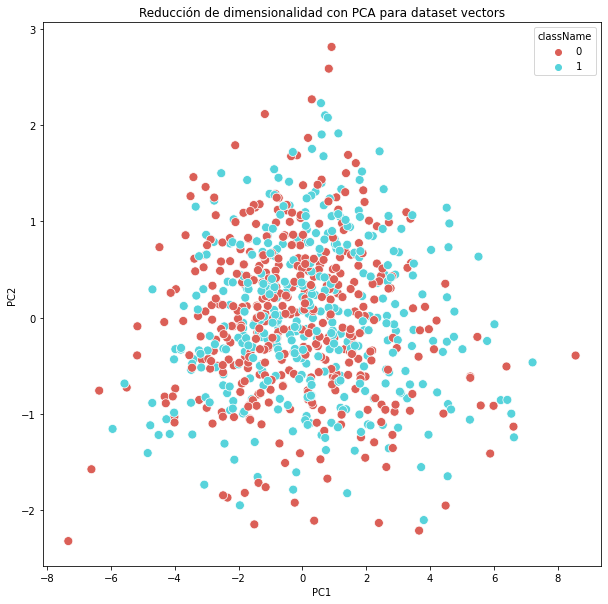

In [8]:
reduceDim(df=vec_df,target=labs_df[0], method_class=PCA, df_name='vectors')

Varianza explicada [0.9295083  0.04933985]
Varianza explicada total 0.97884816


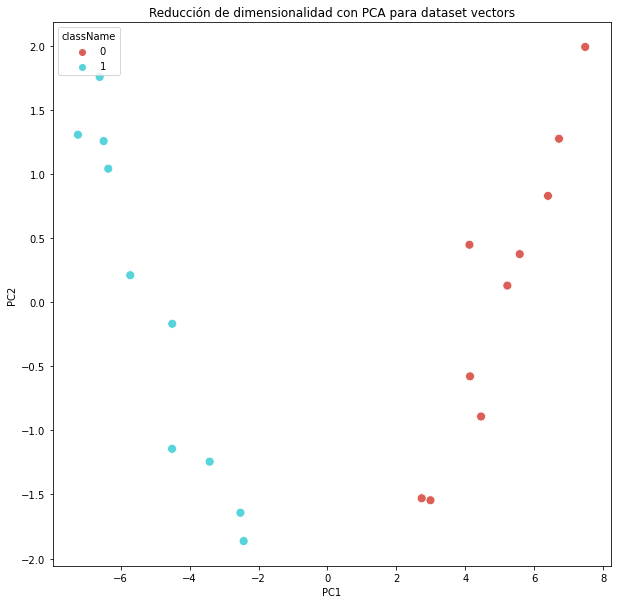

In [9]:
reduceDim(df=vec_df.loc[indices],target=labs_df[0][indices], method_class=PCA, df_name='vectors')

Varianza explicada [0.9295083  0.04933985]
Varianza explicada total 0.97884816


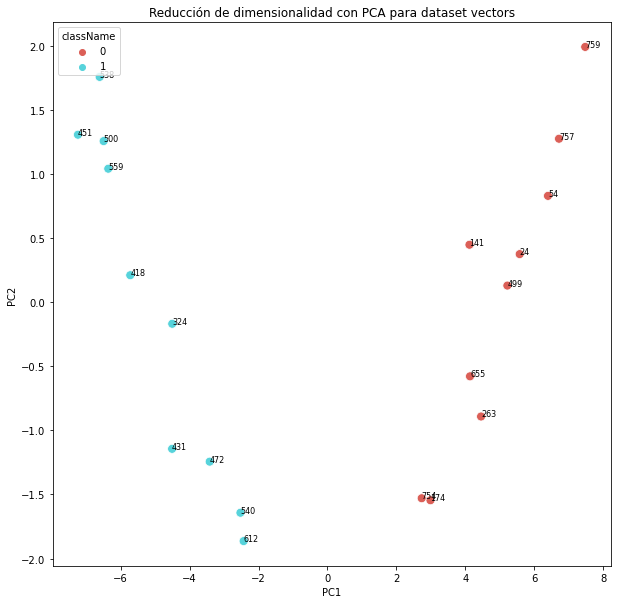

In [10]:
reduceDim(df=vec_df.loc[indices],target=labs_df[0][indices], method_class=PCA, df_name='vectors')
pca = PCA(n_components=2) # apply pca
data2 = pca.fit_transform(vec_df.loc[indices])
for i in range(data2.shape[0]):        
        plt.text(data2[i,0],data2[i,1], indices[i], fontsize=8)

Varianza explicada [0.77080786 0.10539476]
Varianza explicada total 0.87620264


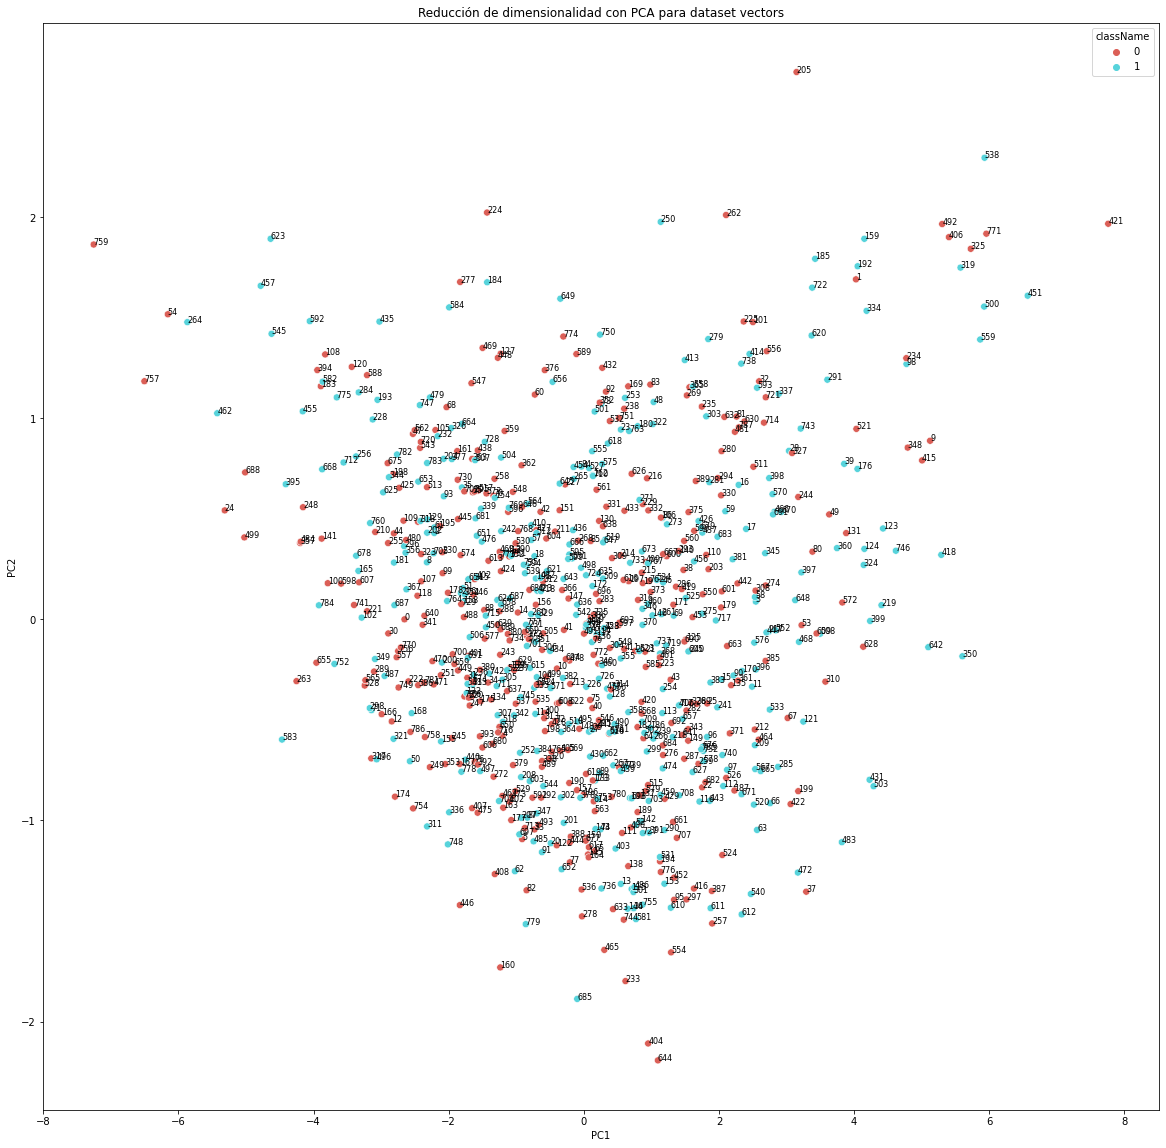

In [ ]:
reduceDim(df=vec_df,target=labs_df[0], method_class=PCA, df_name='vectors')
pca = PCA(n_components=2) # apply pca
data2 = pca.fit_transform(vec_df)
for i in range(data2.shape[0]):        
        plt.text(data2[i,0],data2[i,1], str(i), fontsize=8)

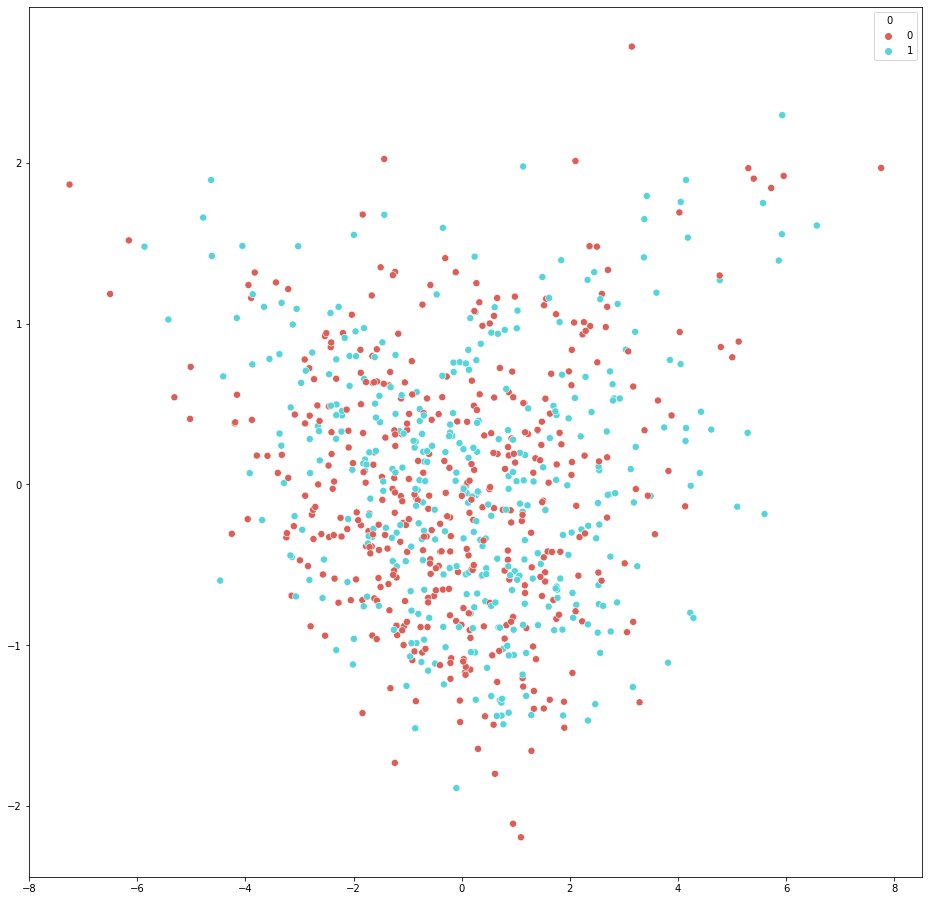

In [ ]:
#pca = PCA(n_components=2) # apply pca
#data2 = pca.fit_transform(vec_df)
fig = plt.figure(figsize = (16,16))
sns.scatterplot(x = data2[:,0], y= data2[:,1],
                    palette=sns.color_palette("hls", 2),
                    hue= labs_df[0],
                s= 50)
#for i in range(data2.shape[0]):        
#        plt.text(data2[i,0],data2[i,1], str(i), fontsize=6)
plt.show()

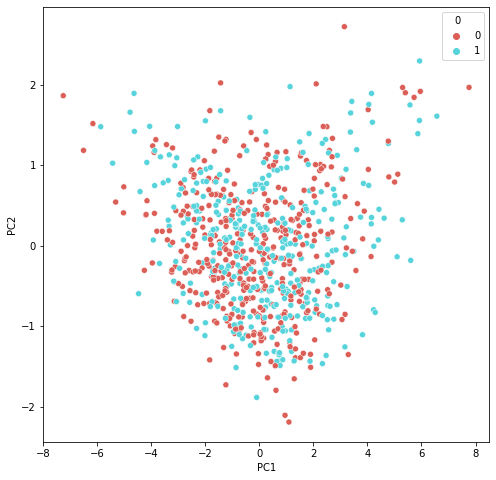

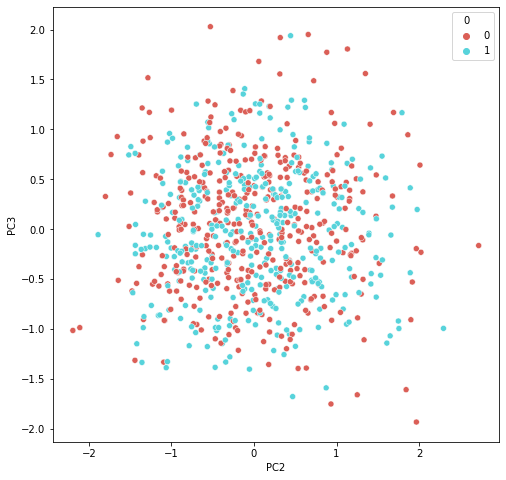

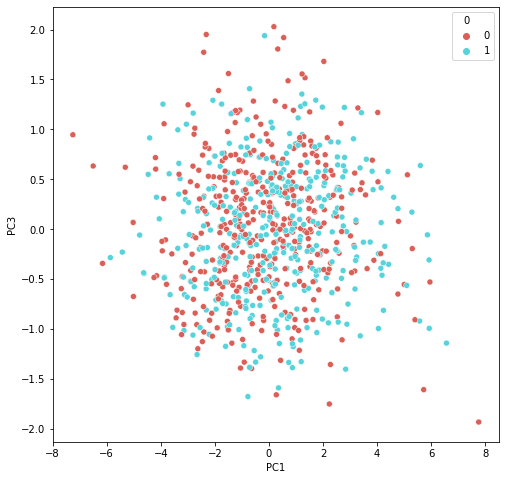

In [ ]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(vec_df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize = (8,8))
sns.scatterplot(data=principalDf[['PC1', 'PC2']], x='PC1', y='PC2',
                    palette=sns.color_palette("hls", 2),
                    hue= labs_df[0])
fig = plt.figure(figsize = (8,8))
sns.scatterplot(data=principalDf[['PC2', 'PC3']], x='PC2', y='PC3',
                    palette=sns.color_palette("hls", 2),
                    hue= labs_df[0])
fig = plt.figure(figsize = (8,8))
sns.scatterplot(data=principalDf[['PC1', 'PC3']], x='PC1', y='PC3',
                    palette=sns.color_palette("hls", 2),
                    hue= labs_df[0])

Lo que podemos hacer también es ver los puntos en los diagramas, que estén a más de un thresh de distancia de la diagonal, y ordenarlos de menor a mayor nacimiento, con un valor de su distancia a la diagonal. Después hacer una secuencia de vectores paddeados, que tengan estos números, y usar eso como vectorización.

# Con Matrices diagonalizadas

In [ ]:
with open('autism-master/train/train_data_fmri_basc197.pkl', 'rb') as handle:
    train_mats = pkl.load(handle)

In [ ]:
lenmat = len(train_mats)
train_diags = []
for i in range(lenmat):
  train_diags.append(train_mats[i]['triang'])


In [ ]:
del train_mats

In [ ]:
train_diags_df = pd.DataFrame(train_diags)

In [ ]:
train_diags_df = train_diags_df.fillna(train_diags_df.mean())

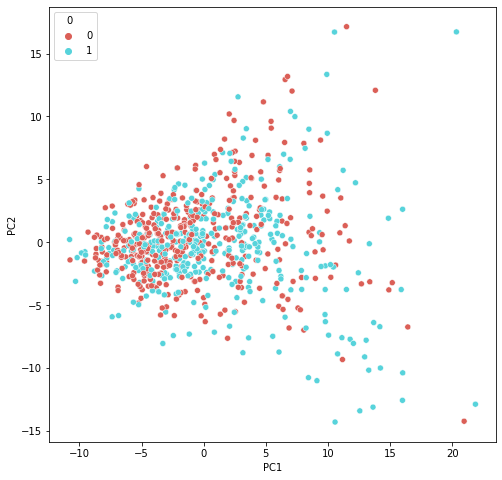

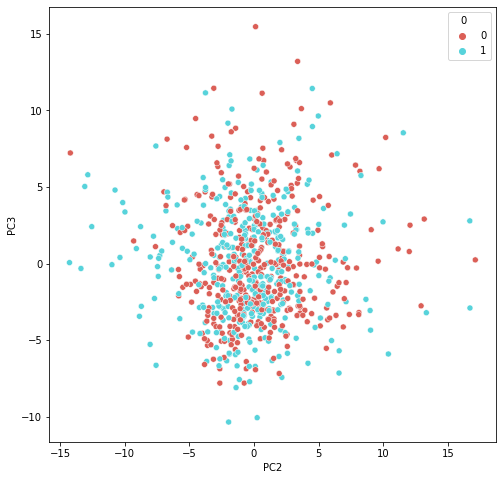

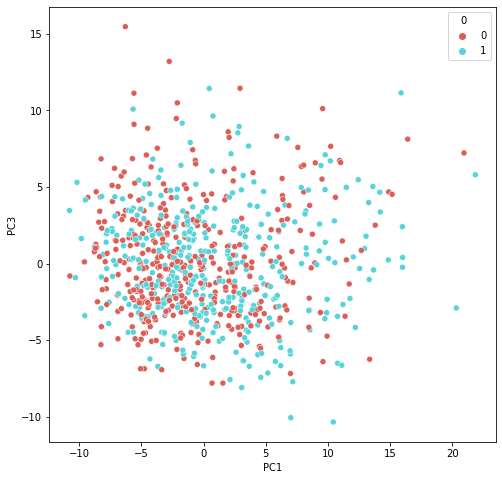

In [ ]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(train_diags_df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize = (8,8))
sns.scatterplot(data=principalDf[['PC1', 'PC2']], x='PC1', y='PC2',
                    palette=sns.color_palette("hls", 2),
                    hue= labs_df[0])
fig = plt.figure(figsize = (8,8))
sns.scatterplot(data=principalDf[['PC2', 'PC3']], x='PC2', y='PC3',
                    palette=sns.color_palette("hls", 2),
                    hue= labs_df[0])
fig = plt.figure(figsize = (8,8))
sns.scatterplot(data=principalDf[['PC1', 'PC3']], x='PC1', y='PC3',
                    palette=sns.color_palette("hls", 2),
                    hue= labs_df[0])

# Overfit Try

Varianza explicada [0.91204154 0.06074558]
Varianza explicada total 0.97278714


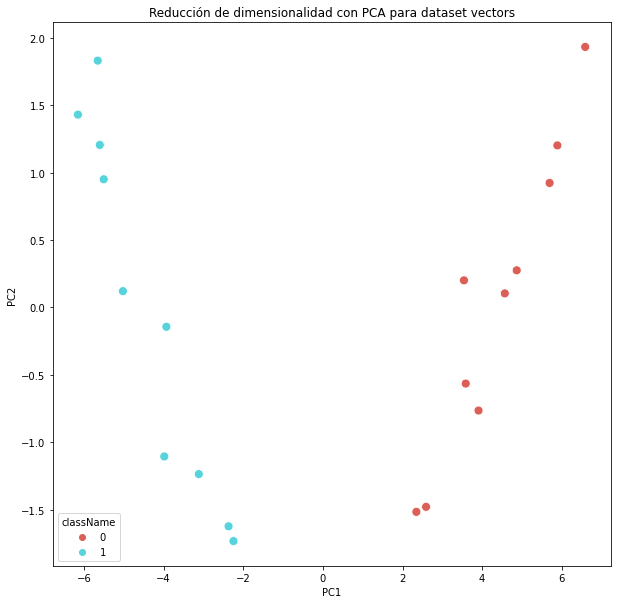

In [ ]:
indices = [759,54,757,24,499,141,655,263,174,754,538,451,500,559,418,431,324,472,540,612]
reduceDim(df=vec_df.loc[indices],target=labs_df[0][indices], method_class=PCA, df_name='vectors')

# otra cosa nada que ver

In [29]:
#vec_df.head()
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(vec_df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

In [27]:
#diags_dict 
labels_df = pd.DataFrame(label_dict)

In [31]:
labels_df

,id,label
0,6362958275326218968,0
1,7111506141037153650,0
2,15632143337475166470,1
3,6025747022351864597,1
4,16653395447554605567,0
...,...,...
783,1481422034939942578,1
784,2994108393674473882,1
785,1220685971125577168,1
786,13738536793884153051,0


In [30]:
principalDf

,PC1,PC2
0,-2.774524,-0.343811
1,4.483963,-1.950718
2,-2.339527,0.374151
3,2.672175,-0.235540
4,-1.247357,0.366318
...,...,...
783,-2.393606,-0.329107
784,-4.017477,-0.985863
785,1.814958,0.690979
786,-2.711246,0.198725


In [42]:
df2 = pd.concat([principalDf, labels_df],ignore_index=False, axis=1)

In [48]:
df2 = df2.iloc[indices]

In [56]:
df2.to_csv("JERO/PCA_indices_clases")

In [ ]:
for i in indices:

plt.scatter(D_clase0_0[:,0],D_clase0_0[:,1])
plt.scatter(D_clase0_1[:,0],D_clase0_1[:,1])
plt.plot([0.,1.4],[0.,1.4])
id=label_dict['label'][i]
plt.title(f"{id}")

In [61]:
label_dict['id'][i]

7111506141037153650

In [64]:
for i in indices:
  D_clase0_0 = diags_dict['Rips_dim_0'][i]
  D_clase0_1 = diags_dict['Rips_dim_1'][i]
  plt.scatter(D_clase0_0[:,0],D_clase0_0[:,1])
  plt.scatter(D_clase0_1[:,0],D_clase0_1[:,1])
  plt.plot([0.,1.4],[0.,1.4])
  id=label_dict['id'][i]
  plt.title(f"{id}")
  plt.savefig(f"JERO/images/dgm_{id}.jpg")
  plt.clf()

<Figure size 432x288 with 0 Axes>

In [65]:
sub1 = diags_dict['Rips_dim_0'][indices]

TypeError: ignored

In [66]:

#diags_dict['Rips_dim_0'][1]

dicti = 

array([[0.        , 0.35496479],
       [0.        , 0.36606011],
       [0.        , 0.37416574],
       [0.        , 0.38987178],
       [0.        , 0.39496836],
       [0.        , 0.41231057],
       [0.        , 0.41472882],
       [0.        , 0.42426407],
       [0.        , 0.42895222],
       [0.        , 0.43358967],
       [0.        , 0.45387223],
       [0.        , 0.45825756],
       [0.        , 0.46260133],
       [0.        , 0.46260133],
       [0.        , 0.46904159],
       [0.        , 0.47116876],
       [0.        , 0.48166379],
       [0.        , 0.48166379],
       [0.        , 0.48373547],
       [0.        , 0.48785242],
       [0.        , 0.49396357],
       [0.        , 0.49598387],
       [0.        , 0.49598387],
       [0.        , 0.49799597],
       [0.        , 0.50990194],
       [0.        , 0.51185936],
       [0.        , 0.51961523],
       [0.        , 0.51961523],
       [0.        , 0.51961523],
       [0.        , 0.52535701],
       [0.

## Modelos Overfitteados

### PersLay

In [ ]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    
    # Final rho network is a simple dense layer to the number of labels 
    rho = tf.keras.Sequential([tf.keras.layers.Dense(L.shape[1], activation="sigmoid", input_shape=(200,))])
    model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)

    # Optimizer is Adam with exponential decay of learning rate and moving average of variables
    lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.01, decay_steps=20, decay_rate=0.5)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
    optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 

    # Loss is cross-entropy
    loss = tf.keras.losses.CategoricalCrossentropy()

    # Metric is accuracy
    metrics = [tf.keras.metrics.CategoricalAccuracy()]

In [ ]:
D0 = []
D1 = []
for i in indices:
  D0.append(D[0][i])
  D1.append(D[1][i])
D0 = np.array(D0)
D1 = np.array(D1)
D_subset = [D0,D1]

In [ ]:
random_perm

array([12,  4,  2, 18,  3, 14, 13, 19,  1, 10, 15,  7,  0, 11, 17,  8,  6,
       16,  9,  5])

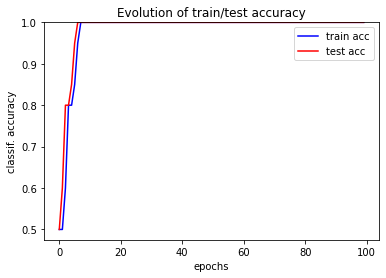

In [ ]:
num_pts = len(D_subset[0])
L_sub = L[indices]
F_sub = F[indices]
epochs    = 100

test_size = .3

random_perm = np.random.permutation(num_pts)
train, test = random_perm, random_perm

_, tr, te = evaluate_model(L_sub,F_sub,D_subset,train,test,model,optimizer,loss,metrics,num_epochs=epochs,verbose=0,plots=True)

### SVM

In [ ]:
vec_sub = vectors[indices]
L_sub_arg = np.argmax(L[indices], axis=1)
L_sub = L[indices]

In [ ]:
# Tenemos la vectorización ya en vectors
svm = SVC()
svm.fit(vec_sub,L_sub_arg)
svm.score(vec_sub, L_sub_arg)

1.0

In [ ]:
diags_subset = []
for ind in indices:
  diags_subset.append(np.array(diags_dict['Rips_dim_1'][ind]))

In [ ]:
diags_dict_subset = {'Rips_dim_0': [],'Rips_dim_1': []}
for i in indices:
  diags_dict_subset['Rips_dim_0'].append(train_dgms[i]['dgm_cor'][0])
  diags_dict_subset['Rips_dim_1'].append(train_dgms[i]['dgm_cor'][1])

In [ ]:
def diag_prepro(diags_dict, use_selector = True, use_prominent = True, thresh = 500, use_scaler = True, use_padding = True):
  
  # https://gudhi.inria.fr/python/3.1.0.rc1/representations.html
  # Whole pipeline
  tmp = Pipeline([
          ("Selector",      tda.DiagramSelector(use=True, point_type="finite")),
          ("ProminentPts",  tda.ProminentPoints(use=True, num_pts=thresh)),
          ("Scaler",        tda.DiagramScaler(use=True, scalers=[([0,1], MinMaxScaler())])),
          ("Padding",       tda.Padding(use=True)),
                  ])

  prm = {filt: {"ProminentPts__num_pts": min(thresh, max([len(dgm) for dgm in diags_dict[filt]]))} 
        for filt in diags_dict.keys() if max([len(dgm) for dgm in diags_dict[filt]]) > 0}

  # Apply the previous pipeline on the different filtrations.
  diags = []
  for dt in prm.keys():
      param = prm[dt]
      tmp.set_params(**param)
      diags.append(tmp.fit_transform(diags_dict[dt]))

  # For each filtration, concatenate all diagrams in a single array.
  D, npts = [], len(diags[0])
  for dt in range(len(prm.keys())):
      D.append(np.array(np.concatenate([diags[dt][i][np.newaxis,:] for i in range(npts)],axis=0),dtype=np.float32))
  
  return D

In [ ]:
D_subset_preproc = diag_prepro(diags_dict_subset, use_selector = False, use_prominent = False, thresh = 40, use_scaler = False, use_padding = False)

In [ ]:
diags_reshape = []
for i in range(len(D_subset_preproc[0])):
  diags_reshape.append(D_subset_preproc[1][i].reshape(-1,3)[:,0:2])

In [ ]:
# SlicedWassersteinKernel
svm = SVC(kernel= 'precomputed')
ker = SlicedWassersteinKernel()
ker_fit = ker.fit_transform(diags_reshape)
svm.fit(ker_fit,L_sub_arg)
svm.score(ker_fit, L_sub_arg)

1.0

In [ ]:
# PersistenceWeightedGaussianKernel
svm = SVC(kernel= 'precomputed')
ker = PersistenceWeightedGaussianKernel()
ker_fit = ker.fit_transform(diags_reshape)
svm.fit(ker_fit,L_sub_arg)
svm.score(ker_fit, L_sub_arg)

0.9

In [ ]:
# PersistenceScaleSpaceKernel
svm = SVC(kernel= 'precomputed')
ker = PersistenceScaleSpaceKernel()
ker_fit = ker.fit_transform(diags_reshape)
svm.fit(ker_fit,L_sub_arg)
svm.score(ker_fit, L_sub_arg)

1.0

In [ ]:
# PersistenceFisherKernel
svm = SVC(kernel= 'precomputed')
ker = PersistenceFisherKernel()
ker_fit = ker.fit_transform(diags_reshape)
svm.fit(ker_fit,L_sub_arg)
svm.score(ker_fit, L_sub_arg)

0.65

con matrices

In [ ]:
train_diags = train_diags_df.loc[indices]

In [ ]:
svm = SVC()
svm.fit(train_diags,L_sub_arg)
svm.score(train_diags, L_sub_arg)

1.0

In [ ]:
# Con todo
num_pts = len(train_diags_df)

test_size = .3
random_perm = np.random.permutation(num_pts)
train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

svm = SVC()
svm.fit(train_diags_df.loc[train],L_arg[train])
svm.score(train_diags_df.loc[test], L_arg[test])

0.6413502109704642

In [ ]:
scores = []
iters = 30
num_pts = len(train_diags_df)
test_size = .3

for i in range(iters):
  print(i)
  random_perm = np.random.permutation(num_pts)
  train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

  svm = SVC()
  svm.fit(train_diags_df.loc[train],L_arg[train])
  scores.append(svm.score(train_diags_df.loc[test], L_arg[test]))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


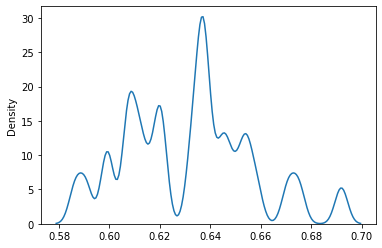

In [ ]:
sns.kdeplot(np.array(scores), bw=0.1)

In [ ]:
scores

[0.6540084388185654,
 0.6075949367088608,
 0.6708860759493671,
 0.6329113924050633,
 0.6371308016877637,
 0.6455696202531646,
 0.6329113924050633,
 0.620253164556962,
 0.5907172995780591,
 0.6455696202531646,
 0.5991561181434599,
 0.6118143459915611,
 0.6751054852320675,
 0.6540084388185654,
 0.6160337552742616,
 0.620253164556962,
 0.5991561181434599,
 0.6413502109704642,
 0.6075949367088608,
 0.6371308016877637,
 0.5864978902953587,
 0.6919831223628692,
 0.6371308016877637,
 0.6371308016877637,
 0.620253164556962,
 0.6497890295358649,
 0.6075949367088608,
 0.6582278481012658,
 0.6118143459915611,
 0.6371308016877637]

Con todo el dataset + holdout

In [ ]:
D = diag_prepro(diags_dict, use_selector = True, use_prominent = False, thresh = 40, use_scaler = True, use_padding = True)
diags_reshape_train = []
for i in range(len(D[0])):
  diags_reshape_train.append(D[1][i].reshape(-1,3)[:,0:2])

In [ ]:
num_pts = len(diags_reshape_train)

test_size = .3
random_perm = np.random.permutation(num_pts)
train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

In [ ]:
diags_train = []
diags_test = []
for i in train:
  diags_train.append(diags_reshape_train[i])
for i in test:
  diags_test.append(diags_reshape_train[i])

In [ ]:
L_arg = np.argmax(L, axis=1)

In [ ]:
# SlicedWassersteinKernel
svm = SVC(kernel= 'precomputed')
ker = SlicedWassersteinKernel()
ker_fit = ker.fit_transform(diags_train)
svm.fit(ker_fit,L_arg[train])
ker_test = ker.transform(diags_test)
svm.score(ker_test, L_arg[test])

0.5147679324894515

dataset + holdout con menos thresh

In [ ]:
D = diag_prepro(diags_dict, use_selector = True, use_prominent = False, thresh = 10, use_scaler = True, use_padding = True)
diags_reshape_train = []
for i in range(len(D[0])):
  diags_reshape_train.append(D[1][i].reshape(-1,3)[:,0:2])

num_pts = len(diags_reshape_train)

test_size = .3
random_perm = np.random.permutation(num_pts)
train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

diags_train = []
diags_test = []
for i in train:
  diags_train.append(diags_reshape_train[i])
for i in test:
  diags_test.append(diags_reshape_train[i])

L_arg = np.argmax(L, axis=1)

In [ ]:
# SlicedWassersteinKernel
svm = SVC(kernel= 'precomputed')
ker = SlicedWassersteinKernel(num_directions=20, bandwidth=.5)
ker_fit = ker.fit_transform(diags_train)
svm.fit(ker_fit,L_arg[train])
ker_test = ker.transform(diags_test)
svm.score(ker_test, L_arg[test])

0.4936708860759494

In [ ]:
sc = []
iters = 30
for i in range(iters):
  print(i)
  random_perm = np.random.permutation(num_pts)
  train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

  diags_train = []
  diags_test = []
  for i in train:
    diags_train.append(diags_reshape_train[i])
  for i in test:
    diags_test.append(diags_reshape_train[i])
  
  ker_fit = ker.fit_transform(diags_train)
  svm.fit(ker_fit,L_arg[train])
  ker_test = ker.transform(diags_test)
  sc.append(svm.score(ker_test, L_arg[test]))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


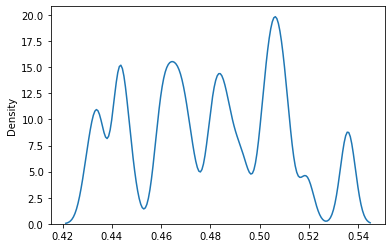

In [ ]:
sns.kdeplot(np.array(sc), bw=0.1)

In [ ]:
sc

[0.5063291139240507,
 0.510548523206751,
 0.4430379746835443,
 0.459915611814346,
 0.5021097046413502,
 0.43037974683544306,
 0.4345991561181435,
 0.48523206751054854,
 0.5021097046413502,
 0.5189873417721519,
 0.4430379746835443,
 0.4810126582278481,
 0.4641350210970464,
 0.4641350210970464,
 0.47257383966244726,
 0.4936708860759494,
 0.4345991561181435,
 0.5063291139240507,
 0.46835443037974683,
 0.46835443037974683,
 0.48523206751054854,
 0.4472573839662447,
 0.510548523206751,
 0.5063291139240507,
 0.48945147679324896,
 0.4430379746835443,
 0.4810126582278481,
 0.5358649789029536,
 0.5358649789029536,
 0.459915611814346]

In [ ]:
vec_df.shape, train_diags_df.shape

((788, 200), (788, 19503))

In [ ]:
svm.predict(train_diags_df.loc[test])

array([1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0])

In [ ]:
# con diagramas + features

scores_both = []
iters = 30
num_pts = len(train_diags_df)
test_size = .3

for i in range(iters):
  print(i)
  random_perm = np.random.permutation(num_pts)
  train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

  svm = SVC()
  svm.fit(train_diags_df.loc[train],L_arg[train])
  scores_both.append(svm.score(train_diags_df.loc[test], L_arg[test]))

In [ ]:
num_pts = len(train_diags_df)
test_size = .3

svm_feat = SVC(probability=True)
svm_diag =  SVC(kernel= 'precomputed', probability=True)
svm_both = SVC()

random_perm = np.random.permutation(num_pts)
train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

svm_feat.fit(train_diags_df.loc[train],L_arg[train])
probs_feat_train = svm_feat.predict_proba(train_diags_df.loc[train])
probs_feat_test = svm_feat.predict_proba(train_diags_df.loc[test])

diags_train = [diags_reshape_train[i] for i in train]
diags_test = [diags_reshape_train[i] for i in test]

ker = SlicedWassersteinKernel(num_directions=20, bandwidth=.5)
ker_fit = ker.fit_transform(diags_train)
svm_diag.fit(ker_fit,L_arg[train])
ker_test = ker.transform(diags_test)
probs_diag_train = svm_diag.predict_proba(ker_fit)
probs_diag_test = svm_diag.predict_proba(ker_test)

probs_train = np.concatenate((probs_feat_train,probs_diag_train), axis=1)
probs_test = np.concatenate((probs_feat_test,probs_diag_test), axis=1)

svm_both.fit(probs_train,L_arg[train])
svm_both.score(probs_test, L_arg[test])


0.5949367088607594

In [ ]:
iters = 30
scores_both = []
num_pts = len(train_diags_df)
test_size = .3

for i in range(iters):
  print(i)
  svm_feat = SVC(probability=True)
  svm_diag =  SVC(kernel= 'precomputed', probability=True)
  svm_both = SVC()

  random_perm = np.random.permutation(num_pts)
  train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

  svm_feat.fit(train_diags_df.loc[train],L_arg[train])
  probs_feat_train = svm_feat.predict_proba(train_diags_df.loc[train])
  probs_feat_test = svm_feat.predict_proba(train_diags_df.loc[test])

  diags_train = [diags_reshape_train[i] for i in train]
  diags_test = [diags_reshape_train[i] for i in test]

  ker = SlicedWassersteinKernel(num_directions=20, bandwidth=.5)
  ker_fit = ker.fit_transform(diags_train)
  svm_diag.fit(ker_fit,L_arg[train])
  ker_test = ker.transform(diags_test)
  probs_diag_train = svm_diag.predict_proba(ker_fit)
  probs_diag_test = svm_diag.predict_proba(ker_test)

  probs_train = np.concatenate((probs_feat_train,probs_diag_train), axis=1)
  probs_test = np.concatenate((probs_feat_test,probs_diag_test), axis=1)

  svm_both.fit(probs_train,L_arg[train])
  scores_both.append(svm_both.score(probs_test, L_arg[test]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [ ]:
scores_both

[0.6582278481012658,
 0.6286919831223629,
 0.6160337552742616,
 0.6075949367088608,
 0.6286919831223629,
 0.6118143459915611,
 0.6329113924050633,
 0.6033755274261603,
 0.569620253164557,
 0.6160337552742616,
 0.6413502109704642,
 0.6118143459915611,
 0.5949367088607594,
 0.6497890295358649,
 0.6244725738396625,
 0.6666666666666666,
 0.6160337552742616,
 0.6160337552742616,
 0.6455696202531646,
 0.6244725738396625,
 0.5949367088607594,
 0.5991561181434599,
 0.6244725738396625,
 0.6118143459915611,
 0.5864978902953587,
 0.6075949367088608,
 0.6455696202531646,
 0.6075949367088608,
 0.5822784810126582,
 0.5738396624472574]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


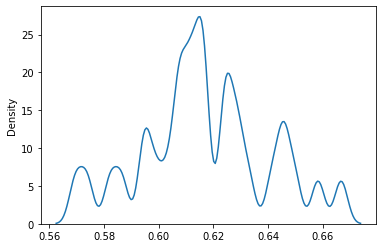

In [ ]:
sns.kdeplot(np.array(scores_both), bw=0.1)

In [ ]:
np.mean(scores_both)

0.6165963431786216

### RF

In [ ]:
# Tenemos la vectorización ya en vectors
rf = RandomForestClassifier()
rf.fit(vec_sub,L_sub_arg)
rf.score(vec_sub, L_sub_arg)

1.0

### NN

In [ ]:
#vec_sub = vectors[indices]
#L_sub_arg = np.argmax(L[indices], axis=1)
#L_sub = L[indices]
vec_sub.shape

(20, 200)

In [ ]:
L_sub.shape

(20, 2)

In [ ]:
d_in = vec_sub.shape[1]
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(3, input_shape=(d_in,), activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 3)                 603       
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 8         
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
  optimizer='adam', 
  loss='categorical_crossentropy', 
  metrics=['accuracy'] 
)

model.fit(vec_sub,L_sub, epochs = 200)

# Plot diagramas lejanos

In [ ]:
D_clase0_0 = diags_dict['Rips_dim_0'][759]
D_clase0_1 = diags_dict['Rips_dim_1'][759]

D_clase1_0 = diags_dict['Rips_dim_0'][538]
D_clase1_1 = diags_dict['Rips_dim_1'][538]

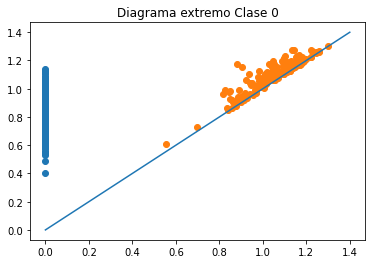

In [ ]:
plt.scatter(D_clase0_0[:,0],D_clase0_0[:,1])
plt.scatter(D_clase0_1[:,0],D_clase0_1[:,1])
plt.plot([0.,1.4],[0.,1.4])
plt.title("Diagrama extremo Clase 0")
plt.show()

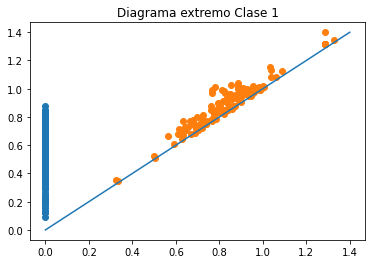

In [ ]:
plt.scatter(D_clase1_0[:,0],D_clase1_0[:,1])
plt.scatter(D_clase1_1[:,0],D_clase1_1[:,1])
plt.plot([0.,1.4],[0.,1.4])
plt.title("Diagrama extremo Clase 1")
plt.show()

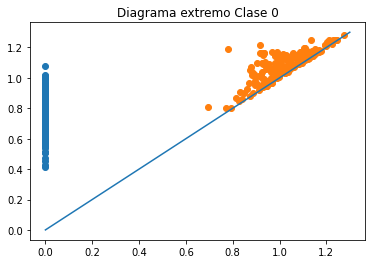

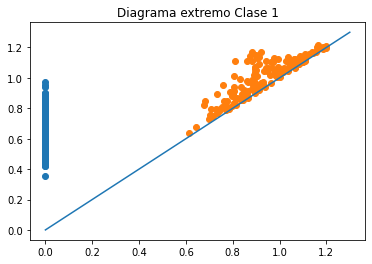

In [ ]:
# Los dos casos de más abajo
# 612 (clase 1) y 754 (clase 0) 
D_clase0_0 = diags_dict['Rips_dim_0'][754]
D_clase0_1 = diags_dict['Rips_dim_1'][754]

D_clase1_0 = diags_dict['Rips_dim_0'][612]
D_clase1_1 = diags_dict['Rips_dim_1'][612]

plt.scatter(D_clase0_0[:,0],D_clase0_0[:,1])
plt.scatter(D_clase0_1[:,0],D_clase0_1[:,1])
plt.plot([0.,1.3],[0.,1.3])
plt.title("Diagrama extremo Clase 0")
plt.show()

plt.scatter(D_clase1_0[:,0],D_clase1_0[:,1])
plt.scatter(D_clase1_1[:,0],D_clase1_1[:,1])
plt.plot([0.,1.3],[0.,1.3])
plt.title("Diagrama extremo Clase 1")
plt.show()

# Prueba Kernels scikit-tda

In [ ]:
!pip install git+https://github.com/MathieuCarriere/sklearn_tda

  Cloning https://github.com/MathieuCarriere/sklearn_tda to /tmp/pip-req-build-bt8c1jqt
  Running command git clone -q https://github.com/MathieuCarriere/sklearn_tda /tmp/pip-req-build-bt8c1jqt
  Running command git submodule update --init --recursive -q
  Created wheel for sklearn-tda: filename=sklearn_tda-0.0.0-cp37-none-any.whl size=23626 sha256=f4cd604e977efea9324c02068f10e4def543559c7962359779e16deb36a90b25
  Stored in directory: /tmp/pip-ephem-wheel-cache-va_y2m2i/wheels/a9/af/e2/d82c9c186ab4bf4cdfc090717ff9e6b78f112fbc51f80df759
Successfully built sklearn-tda


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn_tda import *
from sklearn_tda.preprocessing import Clamping

In [ ]:
D = np.array([[0.,4.],[1.,2.],[3.,8.],[6.,8.], [0., np.inf], [5., np.inf]])
diags = [D]

diags = DiagramSelector(use=True, point_type="finite").fit_transform(diags)
diags = DiagramScaler(use=True, scalers=[([0,1], MinMaxScaler())]).fit_transform(diags)
diags = DiagramScaler(use=True, scalers=[([1], Clamping(limit=.9))]).fit_transform(diags)

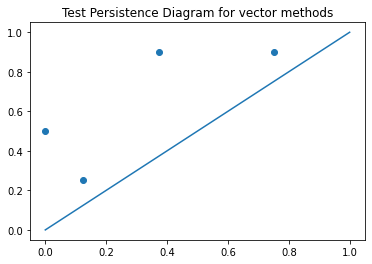

In [ ]:
D = diags[0]
plt.scatter(D[:,0],D[:,1])
plt.plot([0.,1.],[0.,1.])
plt.title("Test Persistence Diagram for vector methods")
plt.show()

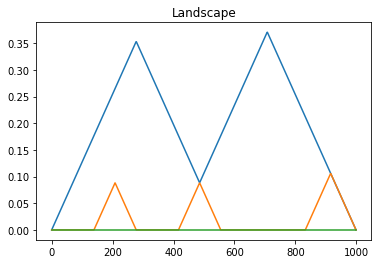

In [ ]:
LS = Landscape(resolution=1000)
L = LS.fit_transform(diags)
plt.plot(L[0][:1000])
plt.plot(L[0][1000:2000])
plt.plot(L[0][2000:3000])
plt.title("Landscape")
plt.show()


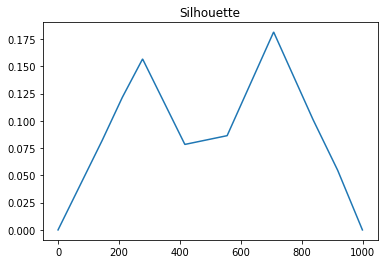

In [ ]:
def pow(n):
  return lambda x: np.power(x[1]-x[0],n)

SH = Silhouette(resolution=1000, weight=pow(2))
sh = SH.fit_transform(diags)
plt.plot(sh[0])
plt.title("Silhouette")
plt.show()

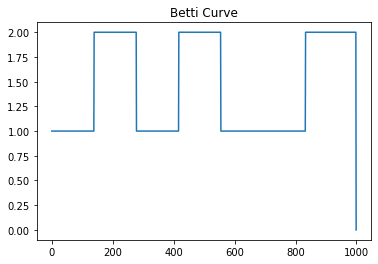

In [ ]:
BC = BettiCurve(resolution=1000)
bc = BC.fit_transform(diags)
plt.plot(bc[0])
plt.title("Betti Curve")
plt.show()


In [ ]:
CP = ComplexPolynomial(threshold=-1, polynomial_type="T")
cp = CP.fit_transform(diags)
print("Complex polynomial is " + str(cp[0,:]))

TV = TopologicalVector(threshold=-1)
tv = TV.fit_transform(diags)
print("Topological vector is " + str(tv[0,:]))

Complex polynomial is [-0.03245984-8.79403907e-01j -0.26344472+2.08975106e-02j
  0.00364472+2.94201744e-02j  0.001202  -2.63174520e-04j]
Topological vector is [0.2625 0.2625 0.075  0.075 ]


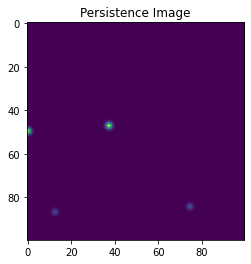

In [ ]:
PI = PersistenceImage(bandwidth=.01, weight=lambda x: x[1], im_range=[0,1,0,1], resolution=[100,100])
pi = PI.fit_transform(diags)
plt.imshow(np.flip(np.reshape(pi[0], [100,100]), 0))
plt.title("Persistence Image")
plt.show()

In [ ]:
ET = Entropy(mode="scalar")
et = ET.fit_transform(diags)
print("Entropy statistic is " + str(et[0,:]))

Entropy statistic is [0.74608589]


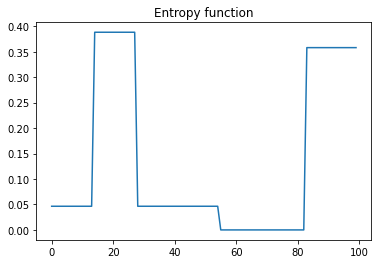

In [ ]:
ET = Entropy(mode="vector", normalized=False)
et = ET.fit_transform(diags)
plt.plot(et[0])
plt.title("Entropy function")
plt.show()

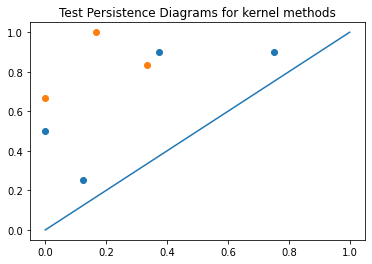

In [ ]:
D = np.array([[1.,5.],[3.,6.],[2.,7.]])
diags2 = [D]

diags2 = DiagramScaler(use=True, scalers=[([0,1], MinMaxScaler())]).fit_transform(diags2)

D = diags[0]
plt.scatter(D[:,0],D[:,1])
D = diags2[0]
plt.scatter(D[:,0],D[:,1])
plt.plot([0.,1.],[0.,1.])
plt.title("Test Persistence Diagrams for kernel methods")
plt.show()

In [ ]:
def arctan(C,p):
  return lambda x: C*np.arctan(np.power(x[1], p))

PWG = PersistenceWeightedGaussianKernel(bandwidth=1., kernel_approx=None, weight=arctan(1.,1.))
X = PWG.fit(diags)
Y = PWG.transform(diags2)
print("PWG kernel is " + str(Y[0][0]))

PWG kernel is 1.6016785633976234


In [ ]:
PWG = PersistenceWeightedGaussianKernel(kernel_approx=RBFSampler(gamma=1./2, n_components=100000).fit(np.ones([1,2])), weight=arctan(1.,1.))
X = PWG.fit(diags)
Y = PWG.transform(diags2)
print("Approximate PWG kernel is " + str(Y[0][0]))

Approximate PWG kernel is 1.5994033548432716


In [ ]:
PSS = PersistenceScaleSpaceKernel(bandwidth=1.)
X = PSS.fit(diags)
Y = PSS.transform(diags2)
print("PSS kernel is " + str(Y[0][0]))

PSS = PersistenceScaleSpaceKernel(kernel_approx=RBFSampler(gamma=1./2, n_components=100000).fit(np.ones([1,2])))
X = PSS.fit(diags)
Y = PSS.transform(diags2)
print("Approximate PSS kernel is " + str(Y[0][0]))

sW = SlicedWassersteinDistance(num_directions=100)
X = sW.fit(diags)
Y = sW.transform(diags2)
print("SW distance is " + str(Y[0][0]))

SW = SlicedWassersteinKernel(num_directions=100, bandwidth=1.)
X = SW.fit(diags)
Y = SW.transform(diags2)
print("SW kernel is " + str(Y[0][0]))

W = BottleneckDistance(epsilon=.001)
X = W.fit(diags)
Y = W.transform(diags2)
print("Bottleneck distance is " + str(Y[0][0]))

PF = PersistenceFisherKernel(bandwidth_fisher=1., bandwidth=1.)
X = PF.fit(diags)
Y = PF.transform(diags2)
print("PF kernel is " + str(Y[0][0]))

PF = PersistenceFisherKernel(bandwidth_fisher=1., bandwidth=1., kernel_approx=RBFSampler(gamma=1./2, n_components=100000).fit(np.ones([1,2])))
X = PF.fit(diags)
Y = PF.transform(diags2)
print("Approximate PF kernel is " + str(Y[0][0]))

PSS kernel is 0.8174721864008387
Approximate PSS kernel is 0.8117986479884504
SW distance is 0.5993200573609824
SW kernel is 0.5491849234187985
Bottleneck distance is 0.250226303747949
PF kernel is 0.9923236265091336
Approximate PF kernel is 0.9922967532219529
